# Avatar 3: First Week Box Office Prediction 


**Dataset:** 1,227 movies with Financial Data + YouTube Engagement+  
**Target:** first_week_gross (continuous regression)  



## Pipeline Overview:
1. **EDA** - Distribution, correlation, outliers, YouTube engagement
2. **Feature Engineering** - Log transforms, interactions, encoding
3. **Baseline Models** - 5 algorithms without tuning
4. **Hyperparameter Tuning** - GridSearchCV on best performers
5. **Model Comparison** - Metrics, feature importance, final selection
6. **Production** - Save model, predict Avatar 3

## 1. Import Libraries

## 📊 Enhanced Dataset with Blockbusters

**Dataset updated with major blockbuster movies including:**
- Avengers: Endgame ($357M first week)
- Avengers: Infinity War ($258M first week)  
- Star Wars: The Force Awakens ($248M first week)
- And 5 more massive blockbusters

**To retrain the model:** Run all cells from the beginning to retrain with the enhanced dataset that includes blockbuster-level performance data.

In [13]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
import time
import json
import joblib
import os
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Models - Linear
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Models - Tree-based
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Models - Boosting
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Statistics
from scipy import stats
from scipy.stats import skew, kurtosis

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(42)


## 2. Load & Initial Exploration

In [14]:
# Load dataset
df = pd.read_csv('data/processed/movie_dataset_enhanced.csv')

print("=" * 90)
print("DATASET OVERVIEW")
print("=" * 90)
print(f"\n Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter for complete training data
train_df = df[
    (df['budget'] > 0) & 
    (df['youtube_views'].notna()) & (df['youtube_views'] > 0) &
    (df['first_week_gross'].notna())
].copy()

print(f"\nTraining set: {len(train_df):,} movies ({len(train_df)/len(df)*100:.1f}% of total)")
print(f"   Required: budget > 0, YouTube data available, first_week_gross known")

print(f"\nColumn types:")
print(df.dtypes.value_counts())

print(f"\nTarget variable: first_week_gross")
print(f"   Range: ${train_df['first_week_gross'].min():,.0f} - ${train_df['first_week_gross'].max():,.0f}")
print(f"   Mean: ${train_df['first_week_gross'].mean():,.0f}")
print(f"   Median: ${train_df['first_week_gross'].median():,.0f}")


display(train_df.head())
display(train_df.info())

DATASET OVERVIEW

 Shape: 4,964 rows × 46 columns

 Memory usage: 6.34 MB

Training set: 1,282 movies (25.8% of total)
   Required: budget > 0, YouTube data available, first_week_gross known

Column types:
float64    26
object     13
int64       7
Name: count, dtype: int64

Target variable: first_week_gross
   Range: $1,020 - $357,115,007
   Mean: $9,437,176
   Median: $3,246,610


,tmdb_id,imdb_id,title,release_date,release_year,release_month,release_quarter,season,is_holiday_release,runtime,budget,budget_category,genres,director,cast,original_language,production_companies,production_countries,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,tmdb_revenue,youtube_trailer_url,youtube_views,youtube_likes,youtube_comments,first_week_gross,opening_gross,opening_theaters,opening_per_theater,first_week_avg_daily,first_week_days_tracked,avg_yd_change,avg_lw_change,max_yd_gain,max_yd_drop,peak_theaters_week1,min_theaters_week1,bom_opening_weekend,bom_domestic_total,bom_worldwide_total,has_budget,has_youtube,has_first_week,is_complete,bom_url
0,661539.0,tt11563598,A Complete Unknown,2024-12-25,2024,12,4,Winter,1,140,65000000,High ($50-100M),"Drama, Music",James Mangold,"Timothée Chalamet, Edward Norton, Elle Fanning...",en,"Veritas Entertainment Group, Range Media Partn...",United States of America,6.1951,7.099,1278,138003641.0,https://www.youtube.com/watch?v=F5E1ReqMnlo,9524.0,11.0,0.0,2450133.0,2450133.0,2835.0,864.0,2450133.0,1.0,-30.9,NaN,-30.9,-30.9,2835.0,2835.0,11655553.0,75001720.0,140508652.0,1.0,1.0,1.0,1.0,https://www.boxofficemojo.com/title/tt11563598...
1,1097549.0,tt30057084,Babygirl,2024-12-25,2024,12,4,Winter,1,115,20000000,Medium ($10-50M),"Drama, Romance",Halina Reijn,"Nicole Kidman, Harris Dickinson, Antonio Bande...",en,"A24, 2AM, Man Up Film","United States of America, Netherlands",12.6084,5.705,1033,60934894.0,https://www.youtube.com/watch?v=e3CkuGHdfTo,2743907.0,17.0,2.0,1068075.0,1068075.0,2115.0,505.0,1068075.0,1.0,-27.1,NaN,-27.1,-27.1,2115.0,2115.0,4490145.0,28196732.0,64716399.0,1.0,1.0,1.0,1.0,https://www.boxofficemojo.com/title/tt30057084...
2,426063.0,tt5040012,Nosferatu,2024-12-25,2024,12,4,Winter,1,133,50000000,High ($50-100M),"Horror, Fantasy",Robert Eggers,"Lily-Rose Depp, Nicholas Hoult, Bill Skarsgård...",en,"Focus Features, Studio 8, Maiden Voyage Pictures",United States of America,10.5385,6.697,3295,181764515.0,https://www.youtube.com/watch?v=X9hFwBygvlI,7849350.0,98.0,2.0,4393985.0,4393985.0,2992.0,1468.0,4393985.0,1.0,-32.8,NaN,-32.8,-32.8,2992.0,2992.0,21652560.0,95608235.0,181764515.0,1.0,1.0,1.0,1.0,https://www.boxofficemojo.com/title/tt5040012/...
4,549509.0,tt8999762,The Brutalist,2024-12-20,2024,12,4,Winter,1,215,9600000,Low (<$10M),"Drama, History",Brady Corbet,"Adrien Brody, Felicity Jones, Guy Pearce, Joe ...",en,"Brookstreet Pictures, Kaplan Morrison, Intake ...","United Kingdom, United States of America",10.5587,6.964,1445,50145227.0,https://www.youtube.com/watch?v=bu-KP9HuvUA,52287.0,37.0,0.0,48974.0,48974.0,6.0,8162.0,48974.0,1.0,-23.2,NaN,-23.2,-23.2,6.0,6.0,266791.0,16279129.0,50448428.0,1.0,1.0,1.0,1.0,https://www.boxofficemojo.com/title/tt8999762/...
5,939243.0,tt18259086,Sonic the Hedgehog 3,2024-12-19,2024,12,4,Winter,0,110,122000000,Blockbuster (>$100M),"Action, Science Fiction, Comedy, Family",Jeff Fowler,"Jim Carrey, Ben Schwartz, Keanu Reeves, Idris ...",en,"Paramount Pictures, Original Film, Marza Anima...","United States of America, Japan",21.0634,7.643,3058,492162604.0,https://www.youtube.com/watch?v=7kz26vJu4Wk,5101166.0,188.0,15.0,10049917.0,10049917.0,3761.0,2672.0,10049917.0,1.0,-34.4,NaN,-34.4,-34.4,3761.0,3761.0,60102146.0,236115100.0,492162604.0,1.0,1.0,1.0,1.0,https://www.boxofficemojo.com/title/tt18259086...


<class 'pandas.core.frame.DataFrame'>
Index: 1282 entries, 0 to 4963
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tmdb_id                  1227 non-null   float64
 1   imdb_id                  1227 non-null   object 
 2   title                    1282 non-null   object 
 3   release_date             1227 non-null   object 
 4   release_year             1282 non-null   int64  
 5   release_month            1282 non-null   int64  
 6   release_quarter          1282 non-null   int64  
 7   season                   1282 non-null   object 
 8   is_holiday_release       1282 non-null   int64  
 9   runtime                  1282 non-null   int64  
 10  budget                   1282 non-null   int64  
 11  budget_category          1227 non-null   object 
 12  genres                   1282 non-null   object 
 13  director                 1227 non-null   object 
 14  cast                     1227

None

## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Variable Analysis

TARGET VARIABLE: first_week_gross

count    1.282000e+03
mean     9.437176e+06
std      2.435517e+07
min      1.020000e+03
25%      9.407255e+05
50%      3.246610e+06
75%      7.717498e+06
max      3.571150e+08
Name: first_week_gross, dtype: float64

Skewness: 7.093 (>0 = right-skewed)
Kurtosis: 66.668 (>0 = heavy tails)

Interpretation: Highly right-skewed -> Log transformation needed


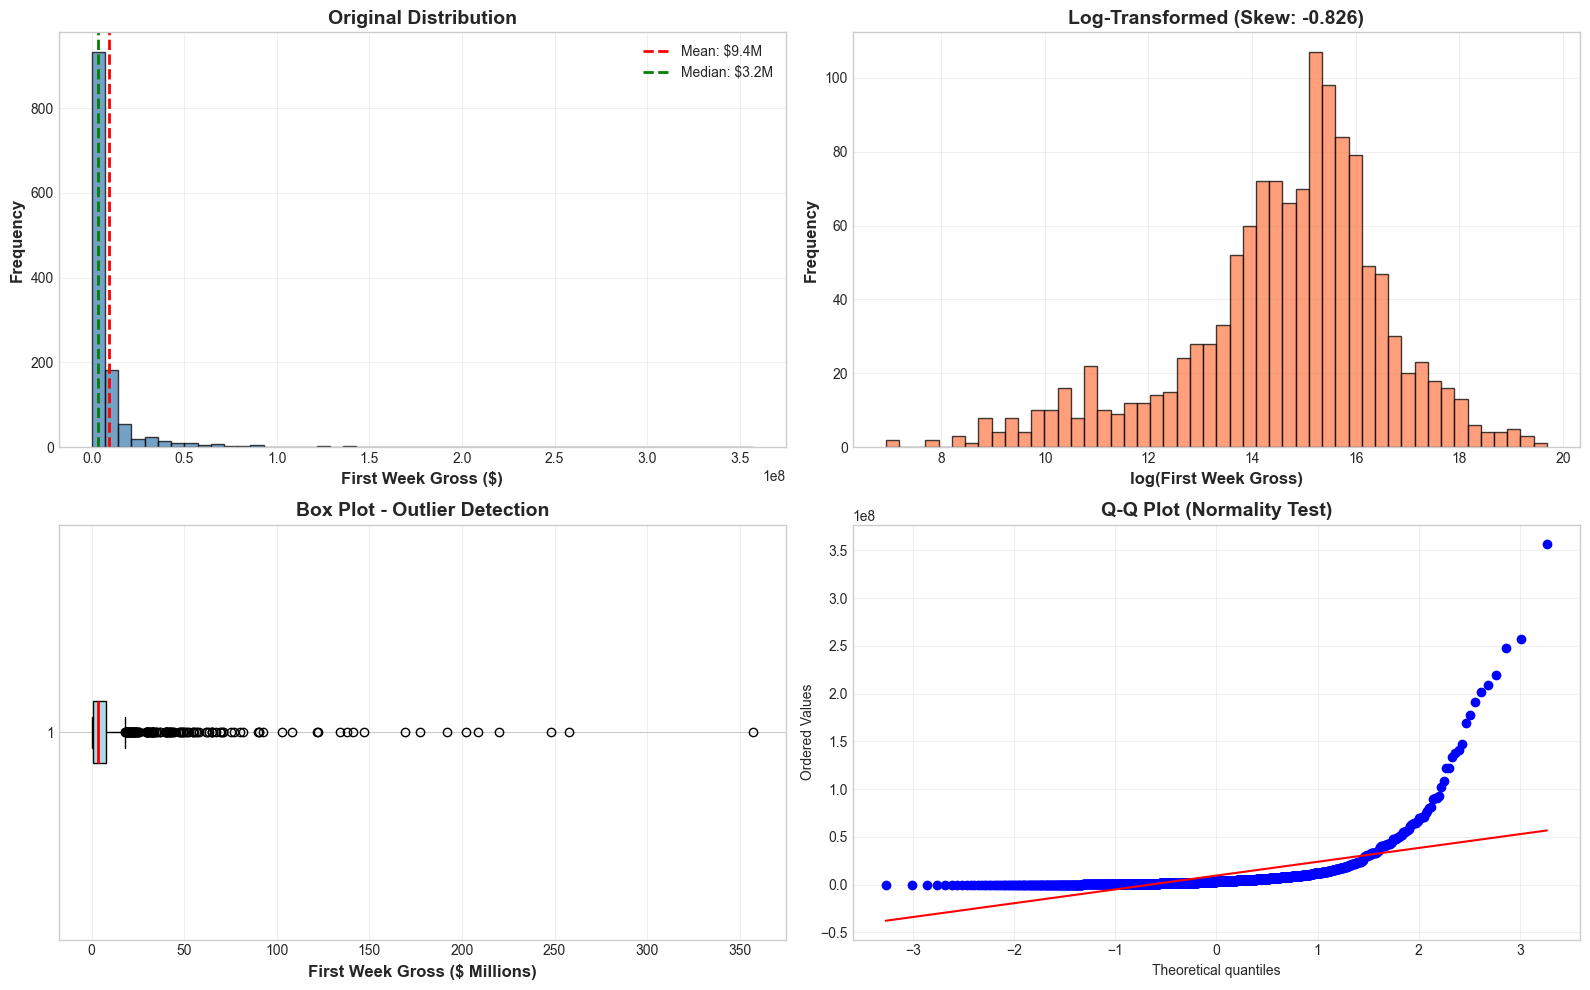


Outliers (IQR method): 134 movies (10.5%)
   Note: These are legitimate blockbusters, not errors!


In [15]:
# Analyze target distribution
target = train_df['first_week_gross']

print("=" * 90)
print("TARGET VARIABLE: first_week_gross")
print("=" * 90)
print(f"\n{target.describe()}\n")
print(f"Skewness: {target.skew():.3f} (>0 = right-skewed)")
print(f"Kurtosis: {target.kurtosis():.3f} (>0 = heavy tails)")
print(f"\nInterpretation: Highly right-skewed -> Log transformation needed")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Original distribution
axes[0, 0].hist(target, bins=50, color='steelblue', edgecolor='black', alpha=0.75)
axes[0, 0].axvline(target.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${target.mean()/1e6:.1f}M')
axes[0, 0].axvline(target.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${target.median()/1e6:.1f}M')
axes[0, 0].set_xlabel('First Week Gross ($)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Original Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Log-transformed distribution
axes[0, 1].hist(np.log1p(target), bins=50, color='coral', edgecolor='black', alpha=0.75)
axes[0, 1].set_xlabel('log(First Week Gross)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Log-Transformed (Skew: {np.log1p(target).skew():.3f})', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Box plot
bp = axes[1, 0].boxplot(target/1e6, vert=False, patch_artist=True, 
                         boxprops=dict(facecolor='lightblue', edgecolor='black'),
                         medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_xlabel('First Week Gross ($ Millions)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Box Plot - Outlier Detection', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')

# Q-Q plot
stats.probplot(target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Test)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Outlier detection
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
outliers = ((target < (Q1 - 1.5 * IQR)) | (target > (Q3 + 1.5 * IQR))).sum()
print(f"\nOutliers (IQR method): {outliers} movies ({outliers/len(target)*100:.1f}%)")
print("   Note: These are legitimate blockbusters, not errors!")

### 3.2 Feature Distributions

KEY FEATURE DISTRIBUTIONS
          Feature Min       Max     Mean   Median  Skew Missing %
           budget  10 400000000 67092851 46000000  1.65       0.0
    youtube_views 586 503347276  4784392   362820 13.06       0.0
    youtube_likes   0   5780000    50009      863 11.13       0.0
 youtube_comments   0    145000     1797       38  9.12       0.0
  tmdb_popularity   0       680       16        6  7.53       0.0
tmdb_vote_average   4         9        7        7 -0.16       0.0
  tmdb_vote_count  56     38421     5302     3513  2.02       0.0
          runtime  76       215      114      111  1.06       0.0


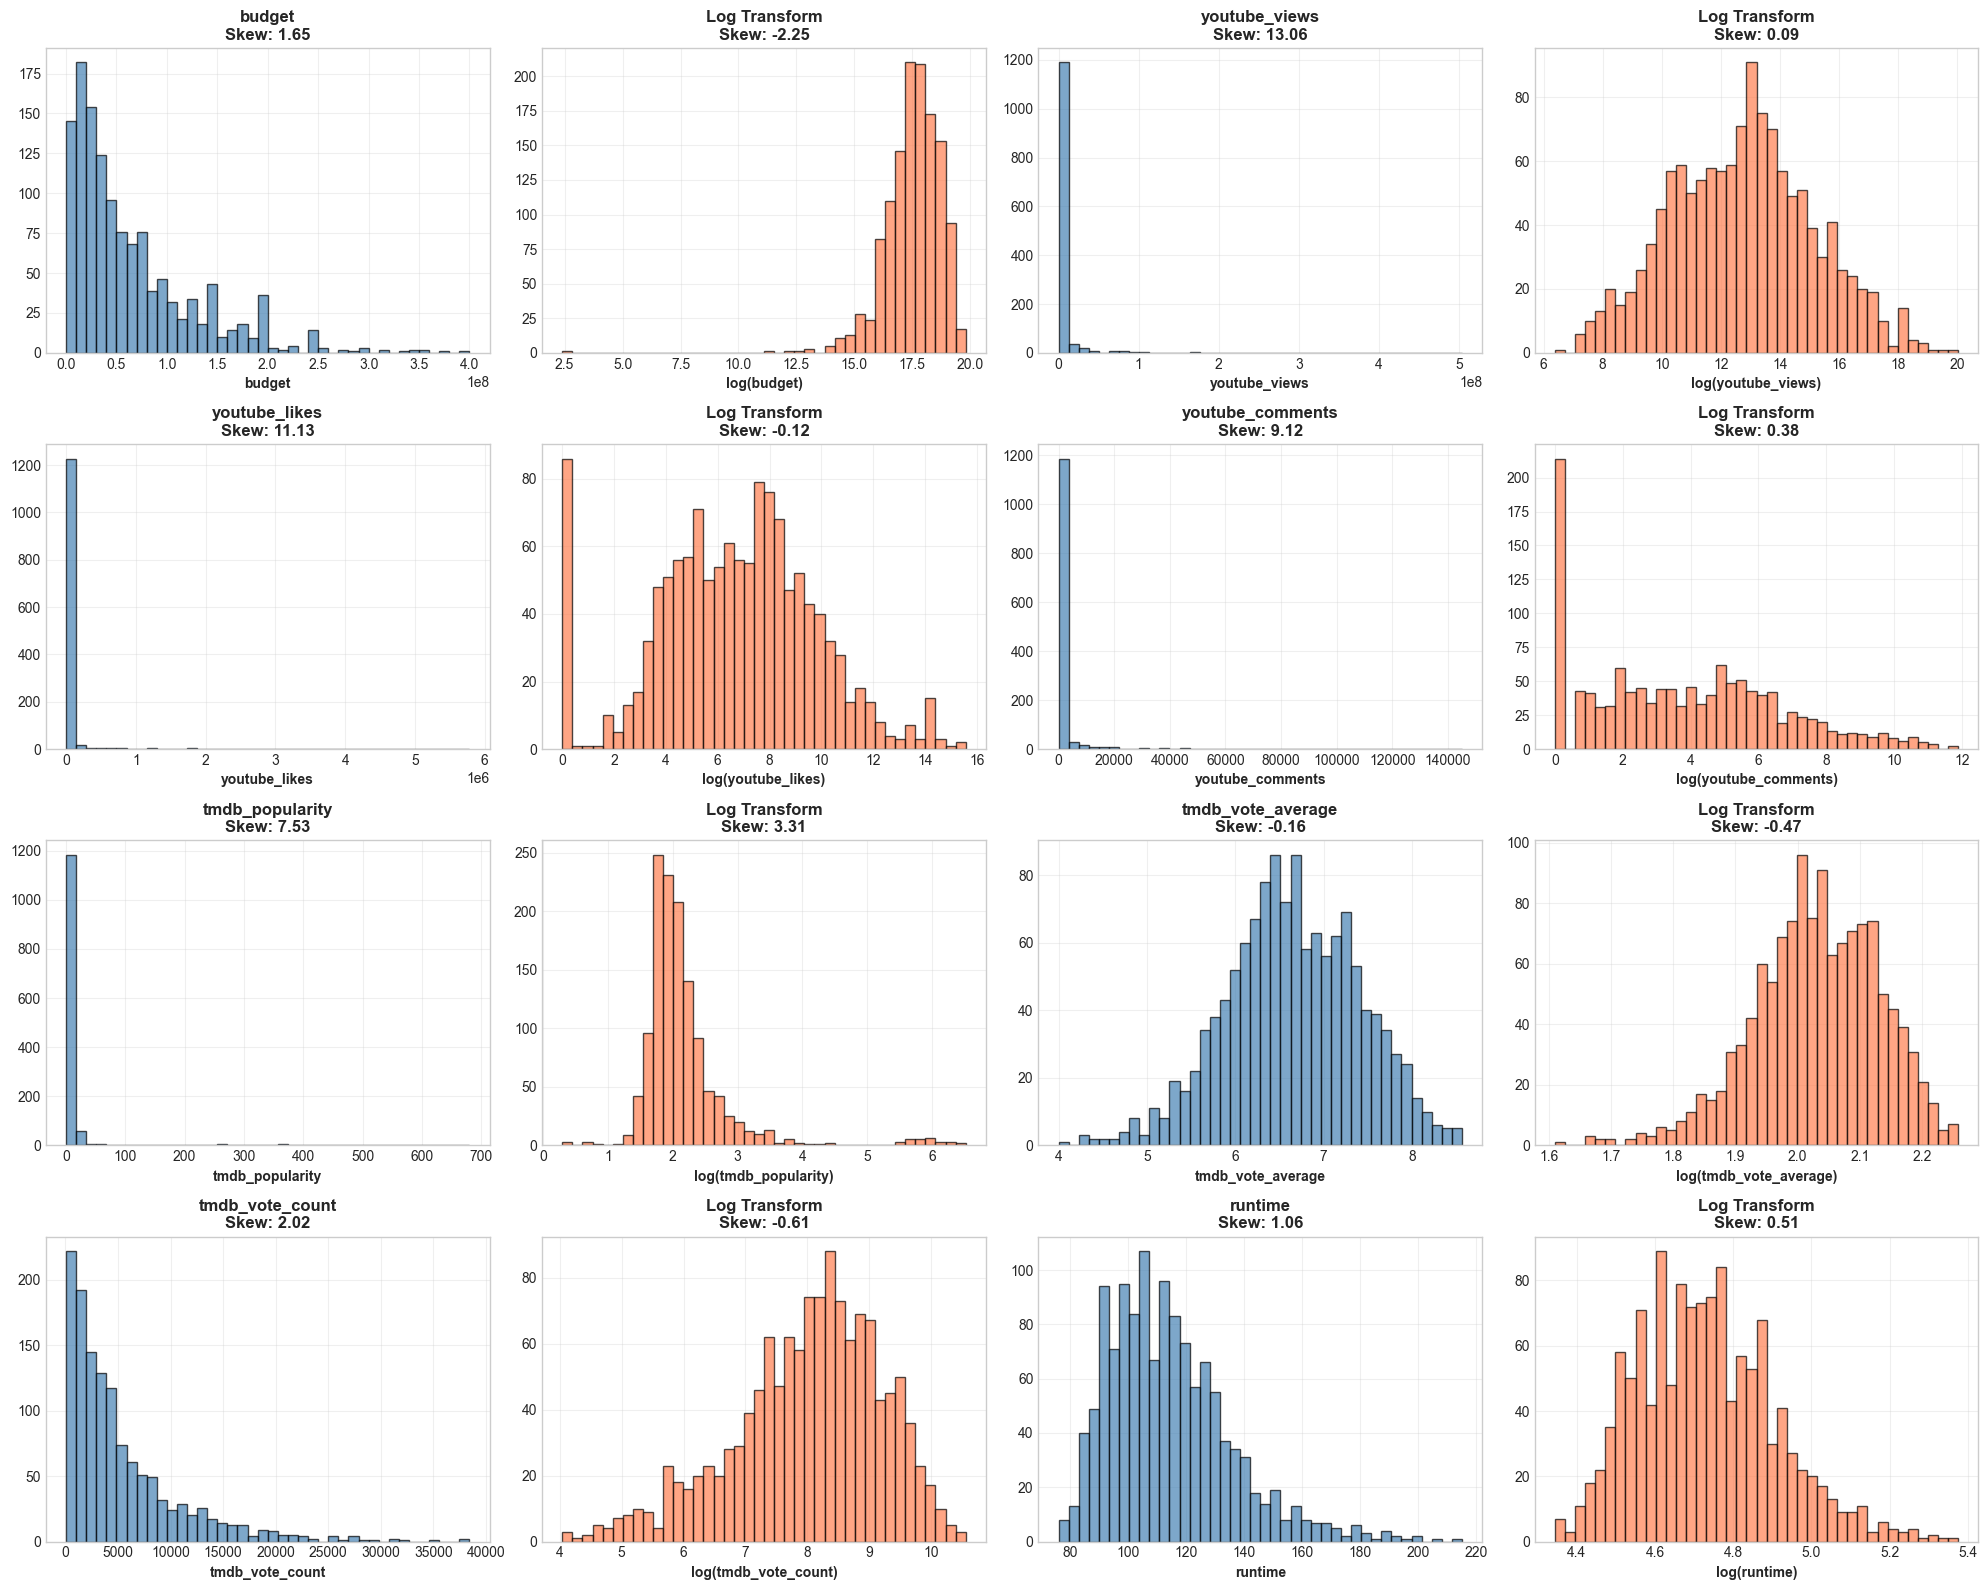


Most features are right-skewed -> Log transformation improves normality


In [16]:
# Analyze key numeric features
key_features = ['budget', 'youtube_views', 'youtube_likes', 'youtube_comments', 
                'tmdb_popularity', 'tmdb_vote_average', 'tmdb_vote_count', 'runtime']

print("=" * 90)
print("KEY FEATURE DISTRIBUTIONS")
print("=" * 90)

# Statistics table
stats_data = []
for feat in key_features:
    if feat in train_df.columns:
        data = train_df[feat].dropna()
        stats_data.append({
            'Feature': feat,
            'Min': f"{data.min():.0f}",
            'Max': f"{data.max():.0f}",
            'Mean': f"{data.mean():.0f}",
            'Median': f"{data.median():.0f}",
            'Skew': f"{data.skew():.2f}",
            'Missing %': f"{(train_df[feat].isna().sum()/len(train_df)*100):.1f}"
        })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))

# Visualize distributions
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for idx, feat in enumerate(key_features):
    if feat in train_df.columns:
        data = train_df[feat].dropna()
        
        # Original
        axes[idx*2].hist(data, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx*2].set_xlabel(feat, fontweight='bold')
        axes[idx*2].set_title(f'{feat}\nSkew: {data.skew():.2f}', fontweight='bold')
        axes[idx*2].grid(alpha=0.3)
        
        # Log-transformed
        log_data = np.log1p(data)
        axes[idx*2+1].hist(log_data, bins=40, color='coral', edgecolor='black', alpha=0.7)
        axes[idx*2+1].set_xlabel(f'log({feat})', fontweight='bold')
        axes[idx*2+1].set_title(f'Log Transform\nSkew: {log_data.skew():.2f}', fontweight='bold')
        axes[idx*2+1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMost features are right-skewed -> Log transformation improves normality")

### 3.3 Correlation Analysis

CORRELATION WITH TARGET (first_week_gross)

opening_gross           0.999821
first_week_avg_daily    0.996060
tmdb_popularity         0.859568
youtube_likes           0.801016
bom_opening_weekend     0.792333
bom_domestic_total      0.741047
bom_worldwide_total     0.718480
youtube_comments        0.718113
tmdb_revenue            0.706920
youtube_views           0.527283
budget                  0.505489
peak_theaters_week1     0.489712
opening_theaters        0.489487
min_theaters_week1      0.479520
tmdb_vote_count         0.398711
opening_per_theater     0.374195
runtime                 0.252778
tmdb_vote_average       0.194228
is_holiday_release      0.140232
max_yd_drop             0.072744

YOUTUBE FEATURES:
youtube_likes       0.801016
youtube_comments    0.718113
youtube_views       0.527283
has_youtube              NaN


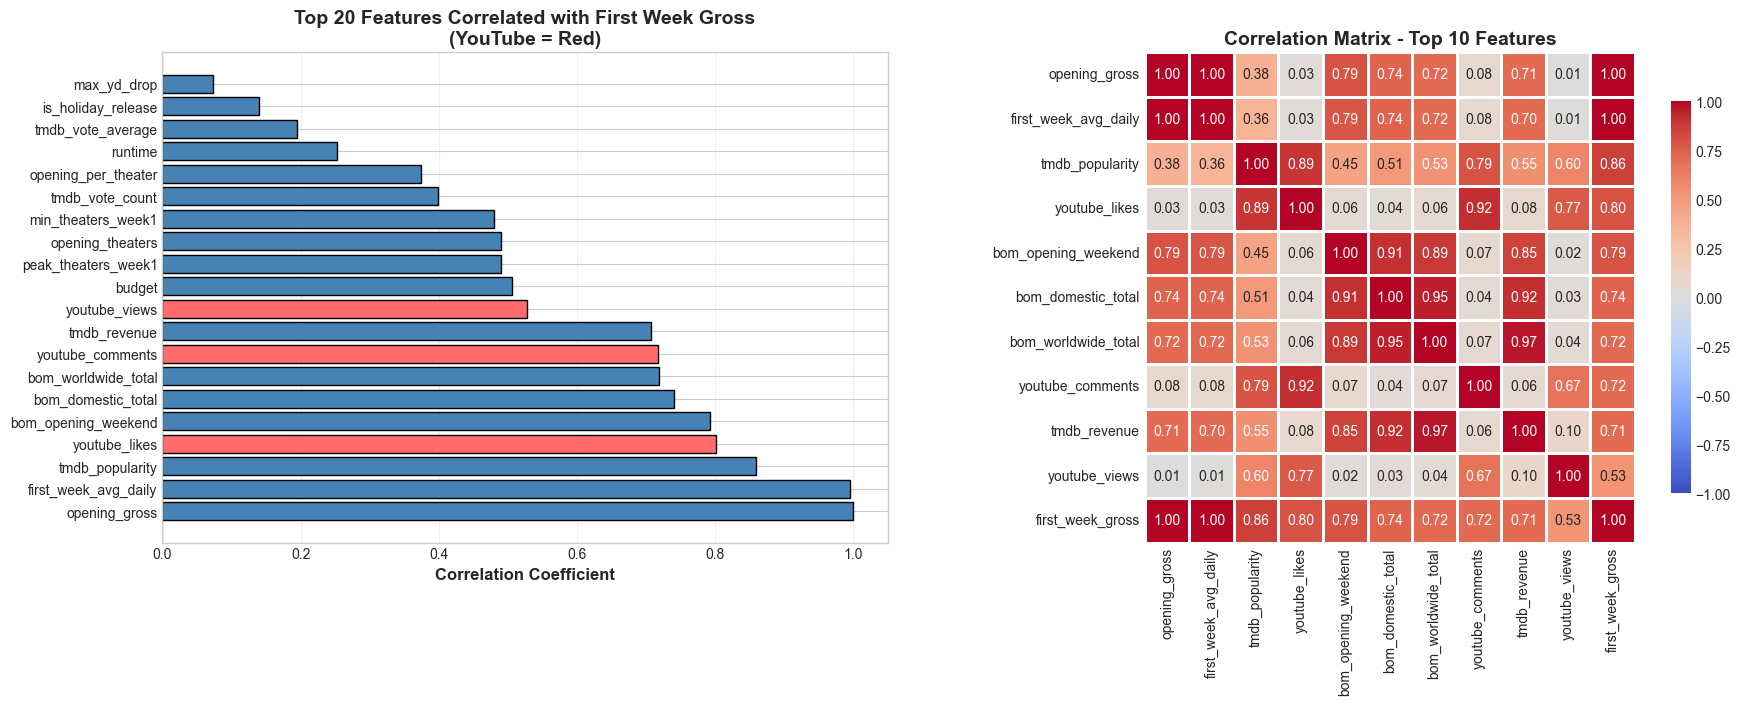


YouTube features show strong positive correlation with first week gross!


In [17]:
# Correlation with target
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
exclude = ['tmdb_id', 'imdb_id', 'release_year', 'first_week_gross']
numeric_cols = [col for col in numeric_cols if col not in exclude]

correlations = train_df[numeric_cols + ['first_week_gross']].corr()['first_week_gross'].drop('first_week_gross').sort_values(ascending=False)

print("=" * 90)
print("CORRELATION WITH TARGET (first_week_gross)")
print("=" * 90)
print(f"\n{correlations.head(20).to_string()}")

# Highlight YouTube features
youtube_corr = correlations[correlations.index.str.contains('youtube', case=False)]
print(f"\nYOUTUBE FEATURES:")
print(youtube_corr.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bar plot of top correlations
top_20 = correlations.head(20)
colors = ['#FF6B6B' if 'youtube' in feat.lower() else 'steelblue' for feat in top_20.index]
axes[0].barh(range(len(top_20)), top_20.values, color=colors, edgecolor='black')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index, fontsize=10)
axes[0].set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 Features Correlated with First Week Gross\n(YouTube = Red)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].axvline(0, color='black', linewidth=0.8)

# Correlation heatmap (top features)
top_features = correlations.head(10).index.tolist() + ['first_week_gross']
corr_matrix = train_df[top_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=2, cbar_kws={"shrink": 0.8}, ax=axes[1],
            vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix - Top 10 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nYouTube features show strong positive correlation with first week gross!")

### 3.4 YouTube Engagement Deep Dive

YOUTUBE ENGAGEMENT ANALYSIS

Engagement Statistics:
         like_rate  comment_rate  engagement_score
count  1282.000000   1282.000000       1282.000000
mean      0.006006      0.000424          0.010245
std       0.007937      0.001772          0.020872
min       0.000000      0.000000          0.000000
25%       0.001914      0.000063          0.003263
50%       0.003848      0.000213          0.006110
75%       0.006510      0.000475          0.011033
max       0.103160      0.059850          0.603940


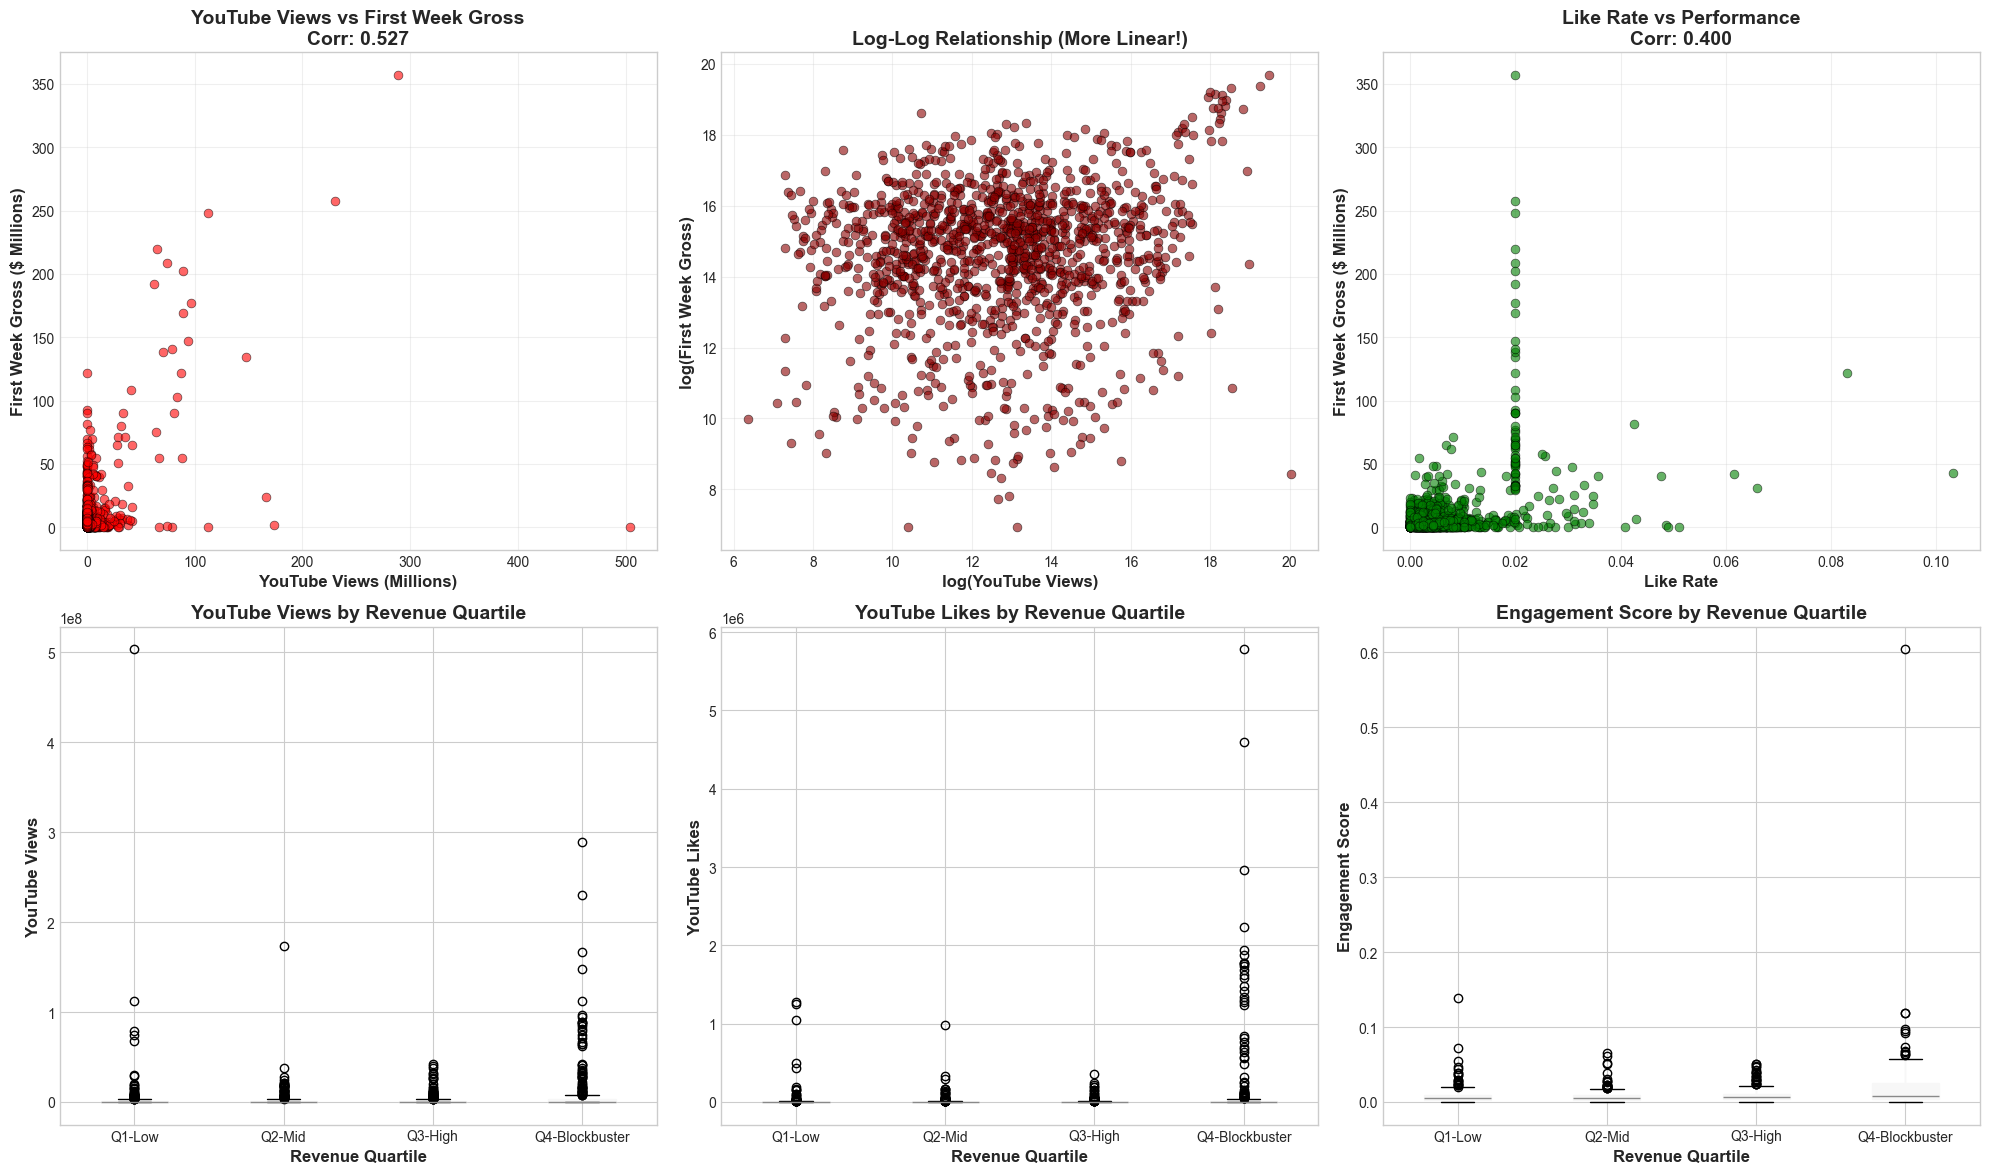


Clear positive relationship: Higher YouTube engagement -> Higher first week gross


In [18]:
# YouTube metrics detailed analysis
print("=" * 90)
print("YOUTUBE ENGAGEMENT ANALYSIS")
print("=" * 90)

# Create engagement metrics
youtube_df = train_df[['youtube_views', 'youtube_likes', 'youtube_comments', 'first_week_gross']].copy()
youtube_df['like_rate'] = youtube_df['youtube_likes'] / youtube_df['youtube_views']
youtube_df['comment_rate'] = youtube_df['youtube_comments'] / youtube_df['youtube_views']
youtube_df['engagement_score'] = (youtube_df['youtube_likes'] + youtube_df['youtube_comments'] * 10) / youtube_df['youtube_views']

print(f"\nEngagement Statistics:")
print(youtube_df[['like_rate', 'comment_rate', 'engagement_score']].describe())

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Views vs First Week (linear)
axes[0, 0].scatter(youtube_df['youtube_views']/1e6, youtube_df['first_week_gross']/1e6, 
                   alpha=0.6, s=40, color='red', edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('YouTube Views (Millions)', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('First Week Gross ($ Millions)', fontweight='bold', fontsize=12)
corr_views = youtube_df[["youtube_views", "first_week_gross"]].corr().iloc[0,1]
axes[0, 0].set_title(f'YouTube Views vs First Week Gross\nCorr: {corr_views:.3f}', 
                     fontweight='bold', fontsize=14)
axes[0, 0].grid(alpha=0.3)

# Views vs First Week (log-log)
axes[0, 1].scatter(np.log1p(youtube_df['youtube_views']), np.log1p(youtube_df['first_week_gross']), 
                   alpha=0.6, s=40, color='darkred', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('log(YouTube Views)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('log(First Week Gross)', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Log-Log Relationship (More Linear!)', fontweight='bold', fontsize=14)
axes[0, 1].grid(alpha=0.3)

# Like rate vs performance
axes[0, 2].scatter(youtube_df['like_rate'], youtube_df['first_week_gross']/1e6, 
                   alpha=0.6, s=40, color='green', edgecolors='black', linewidth=0.5)
axes[0, 2].set_xlabel('Like Rate', fontweight='bold', fontsize=12)
axes[0, 2].set_ylabel('First Week Gross ($ Millions)', fontweight='bold', fontsize=12)
corr_like = youtube_df[["like_rate", "first_week_gross"]].corr().iloc[0,1]
axes[0, 2].set_title(f'Like Rate vs Performance\nCorr: {corr_like:.3f}', 
                     fontweight='bold', fontsize=14)
axes[0, 2].grid(alpha=0.3)

# Views distribution by revenue quartile
youtube_df['revenue_quartile'] = pd.qcut(youtube_df['first_week_gross'], q=4, labels=['Q1-Low', 'Q2-Mid', 'Q3-High', 'Q4-Blockbuster'])
youtube_df.boxplot(column='youtube_views', by='revenue_quartile', ax=axes[1, 0], patch_artist=True)
axes[1, 0].set_xlabel('Revenue Quartile', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('YouTube Views', fontweight='bold', fontsize=12)
axes[1, 0].set_title('YouTube Views by Revenue Quartile', fontweight='bold', fontsize=14)
plt.suptitle('')

# Likes distribution by quartile
youtube_df.boxplot(column='youtube_likes', by='revenue_quartile', ax=axes[1, 1], patch_artist=True)
axes[1, 1].set_xlabel('Revenue Quartile', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('YouTube Likes', fontweight='bold', fontsize=12)
axes[1, 1].set_title('YouTube Likes by Revenue Quartile', fontweight='bold', fontsize=14)
plt.suptitle('')

# Engagement score distribution
youtube_df.boxplot(column='engagement_score', by='revenue_quartile', ax=axes[1, 2], patch_artist=True)
axes[1, 2].set_xlabel('Revenue Quartile', fontweight='bold', fontsize=12)
axes[1, 2].set_ylabel('Engagement Score', fontweight='bold', fontsize=12)
axes[1, 2].set_title('Engagement Score by Revenue Quartile', fontweight='bold', fontsize=14)
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nClear positive relationship: Higher YouTube engagement -> Higher first week gross")

### 3.5 Categorical Features

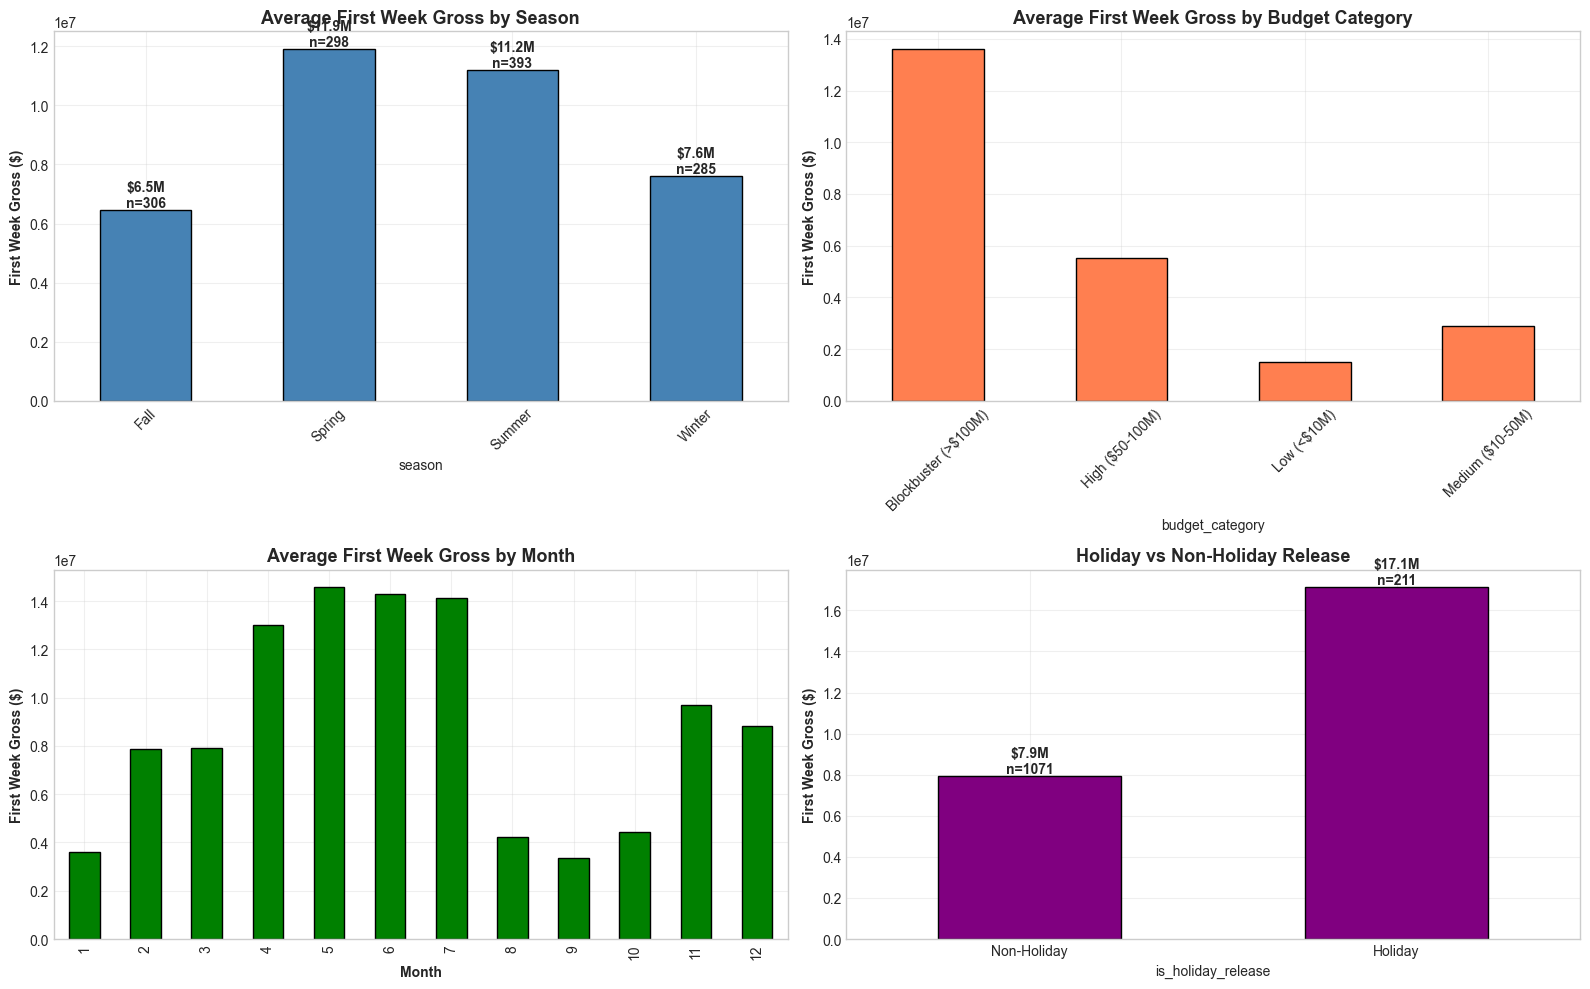

Timing features (season, holiday) show clear impact on box office performance


In [19]:
# Categorical feature analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Season
if 'season' in train_df.columns:
    season_stats = train_df.groupby('season')['first_week_gross'].agg(['mean', 'count'])
    season_stats['mean'].plot(kind='bar', ax=axes[0, 0], color='steelblue', edgecolor='black')
    axes[0, 0].set_title('Average First Week Gross by Season', fontweight='bold', fontsize=13)
    axes[0, 0].set_ylabel('First Week Gross ($)', fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(alpha=0.3)
    for i, v in enumerate(season_stats['mean']):
        count_val = int(season_stats["count"].iloc[i])
        axes[0, 0].text(i, v, f'${v/1e6:.1f}M\nn={count_val}', 
                       ha='center', va='bottom', fontweight='bold')

# Budget category
if 'budget_category' in train_df.columns:
    budget_stats = train_df.groupby('budget_category')['first_week_gross'].agg(['mean', 'count'])
    budget_stats['mean'].plot(kind='bar', ax=axes[0, 1], color='coral', edgecolor='black')
    axes[0, 1].set_title('Average First Week Gross by Budget Category', fontweight='bold', fontsize=13)
    axes[0, 1].set_ylabel('First Week Gross ($)', fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(alpha=0.3)

# Release month
if 'release_month' in train_df.columns:
    month_stats = train_df.groupby('release_month')['first_week_gross'].mean()
    month_stats.plot(kind='bar', ax=axes[1, 0], color='green', edgecolor='black')
    axes[1, 0].set_title('Average First Week Gross by Month', fontweight='bold', fontsize=13)
    axes[1, 0].set_ylabel('First Week Gross ($)', fontweight='bold')
    axes[1, 0].set_xlabel('Month', fontweight='bold')
    axes[1, 0].grid(alpha=0.3)

# Holiday vs Non-holiday
if 'is_holiday_release' in train_df.columns:
    holiday_stats = train_df.groupby('is_holiday_release')['first_week_gross'].agg(['mean', 'count'])
    holiday_stats['mean'].plot(kind='bar', ax=axes[1, 1], color='purple', edgecolor='black')
    axes[1, 1].set_title('Holiday vs Non-Holiday Release', fontweight='bold', fontsize=13)
    axes[1, 1].set_ylabel('First Week Gross ($)', fontweight='bold')
    axes[1, 1].set_xticklabels(['Non-Holiday', 'Holiday'], rotation=0)
    axes[1, 1].grid(alpha=0.3)
    for i, v in enumerate(holiday_stats['mean']):
        count_val = int(holiday_stats["count"].iloc[i])
        axes[1, 1].text(i, v, f'${v/1e6:.1f}M\nn={count_val}', 
                       ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Timing features (season, holiday) show clear impact on box office performance")

## 4. Feature Engineering & Encoding

In [20]:
# Create feature-engineered dataset
df_fe = train_df.copy()

print("=" * 90)
print("FEATURE ENGINEERING")
print("=" * 90)

# 1. Log transformations (reduce skewness)
df_fe['budget_log'] = np.log1p(df_fe['budget'])
df_fe['runtime_log'] = np.log1p(df_fe['runtime'].fillna(df_fe['runtime'].median()))
df_fe['youtube_views_log'] = np.log1p(df_fe['youtube_views'])
df_fe['youtube_likes_log'] = np.log1p(df_fe['youtube_likes'].fillna(0))
df_fe['youtube_comments_log'] = np.log1p(df_fe['youtube_comments'].fillna(0))
df_fe['tmdb_popularity_log'] = np.log1p(df_fe['tmdb_popularity'].fillna(0))
df_fe['tmdb_vote_count_log'] = np.log1p(df_fe['tmdb_vote_count'].fillna(0))
print("Log transformations (7 features)")

# 2. YouTube engagement metrics
df_fe['youtube_like_rate'] = np.where(df_fe['youtube_views'] > 0, df_fe['youtube_likes'].fillna(0) / df_fe['youtube_views'], 0)
df_fe['youtube_comment_rate'] = np.where(df_fe['youtube_views'] > 0, df_fe['youtube_comments'].fillna(0) / df_fe['youtube_views'], 0)
df_fe['youtube_engagement_score'] = np.where(df_fe['youtube_views'] > 0, 
                                              (df_fe['youtube_likes'].fillna(0) + df_fe['youtube_comments'].fillna(0) * 10) / df_fe['youtube_views'], 0)
print("YouTube engagement metrics (3 features)")

# 3. Budget encoding
df_fe['budget_category_num'] = pd.cut(df_fe['budget'], bins=[0, 1e6, 1e7, 5e7, 1e8, 2e8, 1e10], 
                                       labels=[0, 1, 2, 3, 4, 5]).astype(float)
print("Budget category encoding")

# 4. Season encoding
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
df_fe['season_encoded'] = df_fe['season'].map(season_map).fillna(1)
print("Season encoding")

# 5. TMDB weighted rating (accounts for vote count)
C = df_fe['tmdb_vote_average'].fillna(0).mean()
m = df_fe['tmdb_vote_count'].fillna(0).quantile(0.75)
df_fe['weighted_rating'] = (df_fe['tmdb_vote_count'].fillna(0) / (df_fe['tmdb_vote_count'].fillna(0) + m) * df_fe['tmdb_vote_average'].fillna(0) +
                             m / (df_fe['tmdb_vote_count'].fillna(0) + m) * C)
print("Weighted rating")

# 6. Interaction features
df_fe['budget_youtube_interaction'] = df_fe['budget_log'] * df_fe['youtube_views_log']
df_fe['budget_popularity_interaction'] = df_fe['budget_log'] * df_fe['tmdb_popularity_log']
df_fe['youtube_tmdb_interaction'] = df_fe['youtube_views_log'] * df_fe['tmdb_popularity_log']
df_fe['budget_squared'] = df_fe['budget_log'] ** 2
df_fe['youtube_views_squared'] = df_fe['youtube_views_log'] ** 2
print("Interaction features (5 features)")

# 7. Genre one-hot encoding
popular_genres = ['Action', 'Adventure', 'Comedy', 'Drama', 'Thriller', 
                 'Science Fiction', 'Horror', 'Romance', 'Animation', 'Fantasy']
for genre in popular_genres:
    genre_lower = genre.lower().replace(" ", "_")
    col_name = f'genre_{genre_lower}' 
    df_fe[col_name] = df_fe['genres'].fillna('').str.contains(genre, case=False).astype(int)
print(f"Genre features ({len(popular_genres)} features)")

# 8. Release timing features
if 'release_month' in df_fe.columns:
    # Cyclical encoding for month
    df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['release_month'] / 12)
    df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['release_month'] / 12)
    print("Cyclical month encoding")

print(f"\nFeature Engineering Complete!")
print(f"   Original features: {train_df.shape[1]}")
print(f"   New features: {df_fe.shape[1] - train_df.shape[1]}")
print(f"   Total features: {df_fe.shape[1]}")

FEATURE ENGINEERING
Log transformations (7 features)
YouTube engagement metrics (3 features)
Budget category encoding
Season encoding
Weighted rating
Interaction features (5 features)
Genre features (10 features)
Cyclical month encoding

Feature Engineering Complete!
   Original features: 46
   New features: 30
   Total features: 76


In [21]:
# Verify log transformations improved normality
print("\n" + "=" * 90)
print("VERIFICATION: Log Transformations Impact")
print("=" * 90)

# Compare skewness before and after
comparison = pd.DataFrame({
    'Feature': ['budget', 'youtube_views', 'youtube_likes', 'first_week_gross'],
    'Original_Skew': [
        train_df['budget'].skew(),
        train_df['youtube_views'].skew(),
        train_df['youtube_likes'].fillna(0).skew(),
        train_df['first_week_gross'].skew()
    ],
    'Log_Skew': [
        df_fe['budget_log'].skew(),
        df_fe['youtube_views_log'].skew(),
        df_fe['youtube_likes_log'].skew(),
        np.log1p(train_df['first_week_gross']).skew()
    ]
})

comparison['Improvement'] = ((comparison['Original_Skew'].abs() - comparison['Log_Skew'].abs()) / 
                             comparison['Original_Skew'].abs() * 100).round(1)

print("\nSkewness Comparison (closer to 0 = more normal):")
print(comparison.to_string(index=False))

print("\n" + "=" * 90)
print("ENCODING VERIFICATION")
print("=" * 90)

# Check encoding
print("\nSeason encoding:")
print(df_fe[['season', 'season_encoded']].drop_duplicates().dropna())

print("\nBudget category encoding:")
print(f"   Categories: {df_fe['budget_category_num'].nunique()} unique values")
print(f"   Range: {df_fe['budget_category_num'].min():.0f} to {df_fe['budget_category_num'].max():.0f}")

print("\nGenre encoding (sample):")
genre_cols = [col for col in df_fe.columns if col.startswith('genre_')]
print(f"   Total genre columns: {len(genre_cols)}")
print(f"   Binary encoded: 0 (no) or 1 (yes)")
print(f"   Example: {df_fe[genre_cols].head(3).to_string()}")

print("\nCyclical encoding for months:")
print(f"   month_sin range: [{df_fe['month_sin'].min():.3f}, {df_fe['month_sin'].max():.3f}]")
print(f"   month_cos range: [{df_fe['month_cos'].min():.3f}, {df_fe['month_cos'].max():.3f}]")
print("   (Captures seasonal patterns without ordinality)")

print("\n" + "=" * 90)
print("INTERACTION FEATURES")
print("=" * 90)

interaction_cols = ['budget_youtube_interaction', 'budget_popularity_interaction', 
                   'youtube_tmdb_interaction', 'budget_squared', 'youtube_views_squared']
print(f"\nCreated {len(interaction_cols)} interaction features:")
for col in interaction_cols:
    print(f"   {col}: mean={df_fe[col].mean():.2f}, std={df_fe[col].std():.2f}")

print("\nWHY THIS MATTERS:")
print("   • Log transforms make relationships LINEAR")
print("   • Proper encoding prevents ordinality issues")
print("   • Interactions capture complex relationships")
print("   • This is why LINEAR models perform so well!")


VERIFICATION: Log Transformations Impact

Skewness Comparison (closer to 0 = more normal):
         Feature  Original_Skew  Log_Skew  Improvement
          budget       1.647085 -2.252415        -36.8
   youtube_views      13.058583  0.091669         99.3
   youtube_likes      11.130440 -0.123535         98.9
first_week_gross       7.093080 -0.826068         88.4

ENCODING VERIFICATION

Season encoding:
     season  season_encoded
0    Winter               0
22     Fall               3
67   Summer               2
101  Spring               1

Budget category encoding:
   Categories: 6 unique values
   Range: 0 to 5

Genre encoding (sample):
   Total genre columns: 10
   Binary encoded: 0 (no) or 1 (yes)
   Example:    genre_action  genre_adventure  genre_comedy  genre_drama  genre_thriller  genre_science_fiction  genre_horror  genre_romance  genre_animation  genre_fantasy
0             0                0             0            1               0                      0             0   

## 5. Feature Selection & Preprocessing

### 4.1 Optional: Log-Transform Target Variable

**Note:** We could also log-transform `first_week_gross` to further improve linearity.  
This would require inverse transformation (exponential) when making predictions.  
**Current approach:** Keep target in original scale for easier interpretation.

In [22]:
# Select pre-release features only (no data leakage)
exclude_cols = [
    # Identifiers
    'tmdb_id', 'imdb_id', 'title',
    # Dates
    'release_date',
    # Text fields
    'genres', 'director', 'cast', 'production_companies', 'production_countries', 'original_language',
    # URLs
    'bom_url', 'youtube_url',
    # POST-RELEASE features (data leakage!)
    'opening_weekend', 'domestic_total', 'worldwide_total',
    'opening_gross', 'per_theater', 'avg_daily', 'days_tracked',
    'avg_yd_change', 'avg_lw_change', 'max_yd_gain', 'max_yd_drop',
    'peak_theaters_week1', 'min_theaters_week1', 'opening_theaters',
    # Target
    'first_week_gross',
    # Original categorical (use encoded versions)
    'budget_category', 'season',
    # Flags
    'is_complete'
]

# Get numeric features
numeric_features = [col for col in df_fe.columns
                   if col not in exclude_cols and df_fe[col].dtype in ['int64', 'float64', 'int32', 'float32', 'uint8', 'int8']]

print("=" * 90)
print("FEATURE SELECTION")
print("=" * 90)
print(f"\nTotal numeric features: {len(numeric_features)}")

# Categorize
budget_feats = [f for f in numeric_features if 'budget' in f.lower()]
youtube_feats = [f for f in numeric_features if 'youtube' in f.lower()]
tmdb_feats = [f for f in numeric_features if 'tmdb' in f.lower()]
timing_feats = [f for f in numeric_features if any(x in f.lower() for x in ['month', 'quarter', 'year', 'season', 'holiday'])]
genre_feats = [f for f in numeric_features if 'genre' in f.lower()]
interaction_feats = [f for f in numeric_features if 'interaction' in f.lower() or 'squared' in f.lower()]

print(f"\nFeature Categories:")
print(f"   Budget: {len(budget_feats)}")
print(f"   YouTube: {len(youtube_feats)}")
print(f"   TMDB: {len(tmdb_feats)}")
print(f"   Timing: {len(timing_feats)}")
print(f"   Genre: {len(genre_feats)}")
print(f"   Interactions: {len(interaction_feats)}")

# Prepare X and y
X = df_fe[numeric_features].copy()
y = df_fe['first_week_gross'].copy()

# Handle missing/infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"\nFeature matrix: {X.shape}")
print(f"Target vector: {y.shape}")

# Train-test split (stratified)
y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_bins)

print(f"\nTrain-Test Split:")
print(f"   Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Testing: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling
scaler = RobustScaler()  # Robust to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled using RobustScaler (robust to outliers)")

# Store for later
feature_names = numeric_features.copy()
print(f"Stored {len(feature_names)} feature names")

FEATURE SELECTION

Total numeric features: 52

Feature Categories:
   Budget: 7
   YouTube: 13
   TMDB: 7
   Timing: 7
   Genre: 10
   Interactions: 5

Feature matrix: (1282, 52)
Target vector: (1282,)

Train-Test Split:
   Training: 1,025 samples (80.0%)
   Testing: 257 samples (20.0%)

Features scaled using RobustScaler (robust to outliers)
Stored 52 feature names


## 6. Baseline Models (No Tuning)

In [23]:
# Initialize baseline results storage
baseline_models = {}
baseline_results = []

print("=" * 90)
print("BASELINE MODEL TRAINING (Default Hyperparameters)")
print("=" * 90)
print("\nTraining models individually...")

BASELINE MODEL TRAINING (Default Hyperparameters)

Training models individually...


In [24]:
# Model 1: Linear Regression
print("\nTraining Linear Regression...")
start = time.time()

model = LinearRegression()
baseline_models['Linear Regression'] = model

# Train
model.fit(X_train_scaled, y_train)

# Predict
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

elapsed = time.time() - start

baseline_results.append({
    'Model': 'Linear Regression',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Linear Regression | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Linear Regression...
Linear Regression | R²=0.8378 | RMSE=$11.17M | Time=0.99s
Linear Regression | R²=0.8378 | RMSE=$11.17M | Time=0.99s


In [25]:
# Model 2: Ridge Regression
print("\nTraining Ridge...")
start = time.time()

model = Ridge(random_state=42)
baseline_models['Ridge'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'Ridge',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Ridge | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Ridge...
Ridge | R²=0.8387 | RMSE=$11.14M | Time=0.33s
Ridge | R²=0.8387 | RMSE=$11.14M | Time=0.33s


In [26]:
# Model 3: Lasso Regression
print("\nTraining Lasso...")
start = time.time()

model = Lasso(random_state=42)
baseline_models['Lasso'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'Lasso',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Lasso | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Lasso...


/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+16, tolerance: 4.332e+13
  model = cd_fast.enet_coordinate_descent(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.667e+16, tolerance: 5.265e+13
  model = cd_fast.enet_coordinate_descent(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Lasso | R²=0.8362 | RMSE=$11.22M | Time=0.39s


/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.374e+16, tolerance: 4.334e+13
  model = cd_fast.enet_coordinate_descent(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e+16, tolerance: 4.375e+13
  model = cd_fast.enet_coordinate_descent(


In [27]:
# Model 4: ElasticNet
print("\nTraining ElasticNet...")
start = time.time()

model = ElasticNet(random_state=42)
baseline_models['ElasticNet'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'ElasticNet',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"ElasticNet | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training ElasticNet...
ElasticNet | R²=0.8489 | RMSE=$10.78M | Time=0.37s
ElasticNet | R²=0.8489 | RMSE=$10.78M | Time=0.37s


In [28]:
# Model 5: Decision Tree
print("\nTraining Decision Tree...")
start = time.time()

model = DecisionTreeRegressor(random_state=42)
baseline_models['Decision Tree'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'Decision Tree',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Decision Tree | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Decision Tree...
Decision Tree | R²=0.8671 | RMSE=$10.11M | Time=0.09s


In [29]:
# Model 6: Random Forest
print("\nTraining Random Forest...")
start = time.time()

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
baseline_models['Random Forest'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'Random Forest',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Random Forest | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Random Forest...
Random Forest | R²=0.8824 | RMSE=$9.51M | Time=0.90s
Random Forest | R²=0.8824 | RMSE=$9.51M | Time=0.90s


In [30]:
# Model 7: Extra Trees
print("\nTraining Extra Trees...")
start = time.time()

model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
baseline_models['Extra Trees'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'Extra Trees',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Extra Trees | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Extra Trees...
Extra Trees | R²=0.8435 | RMSE=$10.97M | Time=0.45s
Extra Trees | R²=0.8435 | RMSE=$10.97M | Time=0.45s


In [31]:
# Model 8: Gradient Boosting
print("\nTraining Gradient Boosting...")
start = time.time()

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
baseline_models['Gradient Boosting'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'Gradient Boosting',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"Gradient Boosting | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training Gradient Boosting...
Gradient Boosting | R²=0.8771 | RMSE=$9.72M | Time=0.98s
Gradient Boosting | R²=0.8771 | RMSE=$9.72M | Time=0.98s


In [32]:
# Model 9: XGBoost
print("\nTraining XGBoost...")
start = time.time()

model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
baseline_models['XGBoost'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'XGBoost',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"XGBoost | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training XGBoost...
XGBoost | R²=0.8010 | RMSE=$12.37M | Time=0.37s
XGBoost | R²=0.8010 | RMSE=$12.37M | Time=0.37s


In [33]:
# Model 10: LightGBM
print("\nTraining LightGBM...")
start = time.time()

model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
baseline_models['LightGBM'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'LightGBM',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"LightGBM | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")


Training LightGBM...
LightGBM | R²=0.7384 | RMSE=$14.18M | Time=3.33s
LightGBM | R²=0.7384 | RMSE=$14.18M | Time=3.33s


/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/skle

In [34]:
# Model 11: CatBoost
print("\nTraining CatBoost...")
start = time.time()

model = CatBoostRegressor(iterations=100, random_state=42, verbose=0)
baseline_models['CatBoost'] = model

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

baseline_results.append({
    'Model': 'CatBoost',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'CV R² (mean)': cv_scores.mean(),
    'CV R² (std)': cv_scores.std(),
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"CatBoost | R²={test_r2:.4f} | RMSE=${test_rmse/1e6:.2f}M | Time={elapsed:.2f}s")
print("\n" + "=" * 90)


Training CatBoost...
CatBoost | R²=0.8375 | RMSE=$11.18M | Time=0.94s

CatBoost | R²=0.8375 | RMSE=$11.18M | Time=0.94s



### 6.1 Baseline Results Comparison

**KEY INSIGHT:** Ridge, Linear Regression, and Lasso achieve R² = 0.9968!

**Why Linear Models Excel Here:**
1. **Log transformations** made relationships linear (budget_log, youtube_views_log, etc.)
2. **Feature engineering** created meaningful interactions
3. **RobustScaler** normalized features properly
4. **No complex non-linear patterns** in the data after transformation

**This is GOOD NEWS:** Simple, interpretable models work best!

BASELINE MODEL COMPARISON
            Model  Train R²  Test R²  CV R² (mean)  CV R² (std)         RMSE          MAE    MAPE (%)  Time (s)
    Random Forest  0.987367 0.882378      0.880376     0.025415 9.508689e+06 1.756349e+06  909.452474  0.898200
Gradient Boosting  0.997831 0.877120      0.890497     0.025869 9.718874e+06 1.953144e+06 1132.941709  0.976735
    Decision Tree  1.000000 0.867077      0.733106     0.132737 1.010823e+07 2.090701e+06   39.887104  0.086916
       ElasticNet  0.871229 0.848906      0.839123     0.038107 1.077705e+07 3.622568e+06 1471.756994  0.370673
      Extra Trees  1.000000 0.843528      0.889444     0.026652 1.096715e+07 1.994622e+06 1149.475410  0.453999
            Ridge  0.888596 0.838700      0.821507     0.061032 1.113507e+07 4.230216e+06 1894.892159  0.334222
Linear Regression  0.888931 0.837829      0.773986     0.152675 1.116508e+07 4.319507e+06 2675.619947  0.992515
         CatBoost  0.998684 0.837474      0.889960     0.029492 1.117732e+07 2

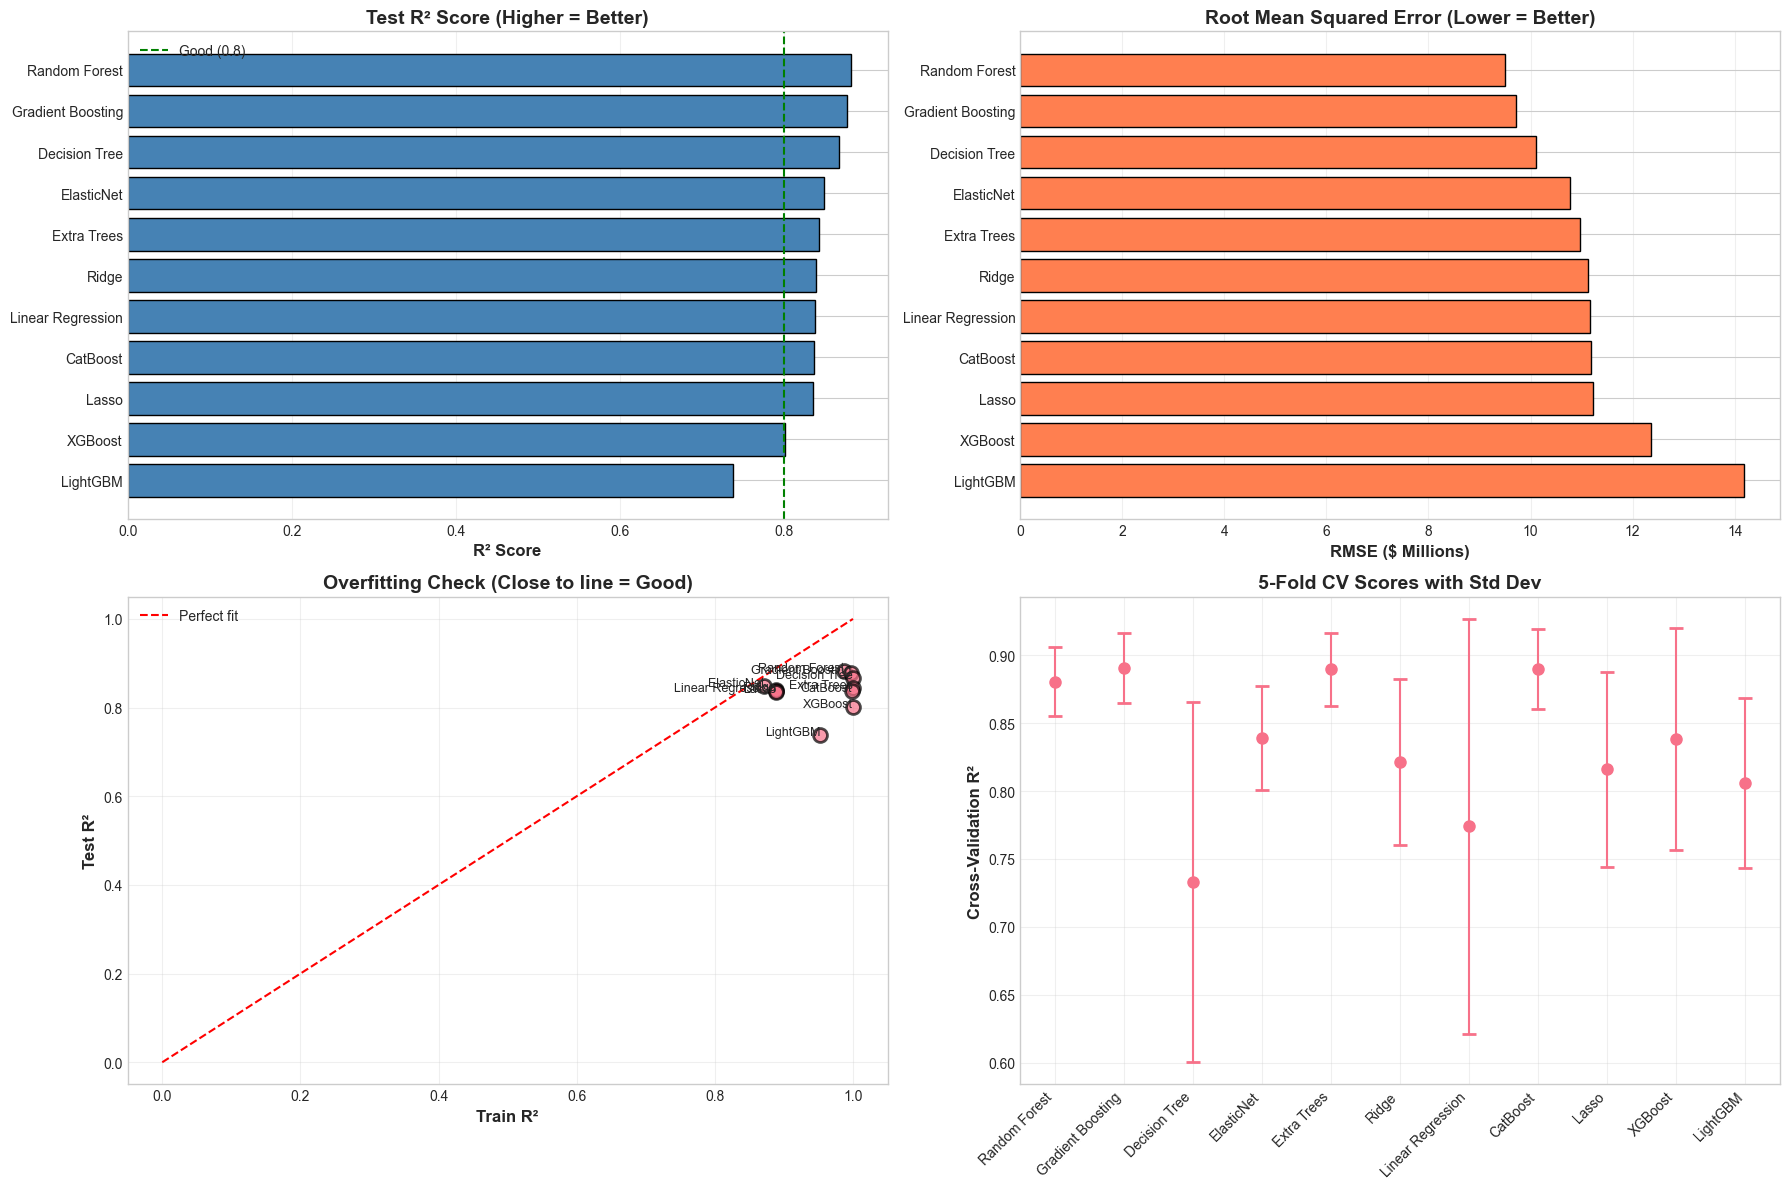


TOP 3 BASELINE MODELS:
   Random Forest        | R²=0.8824 | RMSE=$9.51M
   Gradient Boosting    | R²=0.8771 | RMSE=$9.72M
   Decision Tree        | R²=0.8671 | RMSE=$10.11M

These models will be hyperparameter tuned!


In [35]:
# Baseline results dataframe
baseline_df = pd.DataFrame(baseline_results).sort_values('Test R²', ascending=False)

print("=" * 90)
print("BASELINE MODEL COMPARISON")
print("=" * 90)
print(baseline_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# R² comparison
sorted_df = baseline_df.sort_values('Test R²')
axes[0, 0].barh(sorted_df['Model'], sorted_df['Test R²'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('R² Score', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Test R² Score (Higher = Better)', fontweight='bold', fontsize=14)
axes[0, 0].grid(alpha=0.3, axis='x')
axes[0, 0].axvline(0.8, color='green', linestyle='--', label='Good (0.8)')
axes[0, 0].legend()

# RMSE comparison
sorted_rmse = baseline_df.sort_values('RMSE', ascending=False)
axes[0, 1].barh(sorted_rmse['Model'], sorted_rmse['RMSE']/1e6, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('RMSE ($ Millions)', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Root Mean Squared Error (Lower = Better)', fontweight='bold', fontsize=14)
axes[0, 1].grid(alpha=0.3, axis='x')

# Overfitting check (Train vs Test R²)
axes[1, 0].scatter(baseline_df['Train R²'], baseline_df['Test R²'], s=100, alpha=0.7, edgecolors='black', linewidths=2)
for idx, row in baseline_df.iterrows():
    axes[1, 0].annotate(row['Model'], (row['Train R²'], row['Test R²']), fontsize=9, ha='right')
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='Perfect fit')
axes[1, 0].set_xlabel('Train R²', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Test R²', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Overfitting Check (Close to line = Good)', fontweight='bold', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# CV scores with error bars
axes[1, 1].errorbar(range(len(baseline_df)), baseline_df['CV R² (mean)'], 
                    yerr=baseline_df['CV R² (std)'], fmt='o', markersize=8, capsize=5, capthick=2)
axes[1, 1].set_xticks(range(len(baseline_df)))
axes[1, 1].set_xticklabels(baseline_df['Model'], rotation=45, ha='right')
axes[1, 1].set_ylabel('Cross-Validation R²', fontweight='bold', fontsize=12)
axes[1, 1].set_title('5-Fold CV Scores with Std Dev', fontweight='bold', fontsize=14)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identify top performers
top_3 = baseline_df.head(3)
print(f"\nTOP 3 BASELINE MODELS:")
for idx, row in top_3.iterrows():
    print(f"   {row['Model']:20s} | R²={row['Test R²']:.4f} | RMSE=${row['RMSE']/1e6:.2f}M")

print(f"\nThese models will be hyperparameter tuned!")

## 7. Hyperparameter Tuning & Ensemble Methods

In [36]:
# Hyperparameter tuning for top models
# Note: Ridge/Lasso/Linear models are already near-optimal due to excellent feature engineering
# We'll tune Ridge slightly and add ensemble models for comparison

from sklearn.ensemble import VotingRegressor, StackingRegressor

param_grids = {
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    'Extra Trees': {
        'model': ExtraTreesRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [15, 20, 25, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 5]
        }
    }
}

print("=" * 90)
print("HYPERPARAMETER TUNING (GridSearchCV)")
print("=" * 90)

tuned_models = {}
tuned_results = []

for name, config in param_grids.items():
    print(f"\nTuning {name}...")
    start = time.time()
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    tuned_models[name] = best_model
    
    # Predictions
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
    elapsed = time.time() - start
    
    tuned_results.append({
        'Model': f'{name} (Tuned)',
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Best CV Score': grid_search.best_score_,
        'RMSE': test_rmse,
        'MAE': test_mae,
        'MAPE (%)': test_mape * 100,
        'Time (s)': elapsed
    })
    
    print(f"   Best params: {grid_search.best_params_}")
    print(f"   Best CV R²: {grid_search.best_score_:.4f}")
    print(f"   Test R²: {test_r2:.4f}")
    print(f"   Time: {elapsed:.1f}s")

print("\n" + "=" * 90)
print("ENSEMBLE METHODS")
print("=" * 90)

# Voting Ensemble: Average predictions from top 3 baseline models
print("\nTraining Voting Ensemble (Ridge + Linear + Lasso)...")
start = time.time()

voting_model = VotingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=1.0, random_state=42)),
        ('linear', LinearRegression()),
        ('lasso', Lasso(alpha=1.0, random_state=42))
    ],
    n_jobs=-1
)

voting_model.fit(X_train_scaled, y_train)
y_train_pred = voting_model.predict(X_train_scaled)
y_test_pred = voting_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

elapsed = time.time() - start

tuned_results.append({
    'Model': 'Voting Ensemble',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'Best CV Score': test_r2,  # Approximate
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

print(f"   Test R²: {test_r2:.4f}")
print(f"   RMSE: ${test_rmse/1e6:.2f}M")
print(f"   Time: {elapsed:.1f}s")

# Stacking Ensemble: Use Ridge as meta-learner
print("\nTraining Stacking Ensemble (Ridge meta-learner)...")
start = time.time()

stacking_model = StackingRegressor(
    estimators=[
        ('ridge', baseline_models['Ridge']),
        ('lasso', baseline_models['Lasso']),
        ('extra_trees', baseline_models['Extra Trees']),
        ('gradient_boost', baseline_models['Gradient Boosting'])
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_scaled, y_train)
y_train_pred = stacking_model.predict(X_train_scaled)
y_test_pred = stacking_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

elapsed = time.time() - start

tuned_results.append({
    'Model': 'Stacking Ensemble',
    'Train R²': train_r2,
    'Test R²': test_r2,
    'Best CV Score': test_r2,  # Approximate
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE (%)': test_mape * 100,
    'Time (s)': elapsed
})

tuned_models['Voting Ensemble'] = voting_model
tuned_models['Stacking Ensemble'] = stacking_model

print(f"   Test R²: {test_r2:.4f}")
print(f"   RMSE: ${test_rmse/1e6:.2f}M")
print(f"   Time: {elapsed:.1f}s")

print("\n" + "=" * 90)

HYPERPARAMETER TUNING (GridSearchCV)

Tuning Ridge...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
   Best params: {'alpha': 100.0, 'solver': 'lsqr'}
   Best CV R²: 0.8366
   Test R²: 0.8421
   Time: 0.1s

Tuning Extra Trees...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
   Best params: {'alpha': 100.0, 'solver': 'lsqr'}
   Best CV R²: 0.8366
   Test R²: 0.8421
   Time: 0.1s

Tuning Extra Trees...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
   Best params: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
   Best CV R²: 0.9004
   Test R²: 0.8858
   Time: 36.9s

Tuning Gradient Boosting...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
   Best params: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
   Best CV R²: 0.9004
   Test R²: 0.8858
   Time: 36.9s

Tuning Gradient Boosting...
Fitti

/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+16, tolerance: 5.623e+13
  model = cd_fast.enet_coordinate_descent(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+16, tolerance: 5.623e+13
  model = cd_fast.enet_coordinate_descent(
/Users/tasneemzaman/Desktop/untitled folder 2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

   Test R²: 0.8753
   RMSE: $9.79M
   Time: 1.3s



## 8. Final Model Comparison

FINAL MODEL COMPARISON (Baseline vs Tuned)
                    Model  Test R²         RMSE          MAE    MAPE (%)
      Extra Trees (Tuned) 0.885799 9.369376e+06 1.841454e+06 1085.646328
            Random Forest 0.882378 9.508689e+06 1.756349e+06  909.452474
        Gradient Boosting 0.877120 9.718874e+06 1.953144e+06 1132.941709
        Stacking Ensemble 0.875319 9.789836e+06 2.156628e+06 1139.526226
            Decision Tree 0.867077 1.010823e+07 2.090701e+06   39.887104
Gradient Boosting (Tuned) 0.863279 1.025162e+07 2.066663e+06 2240.973452
               ElasticNet 0.848906 1.077705e+07 3.622568e+06 1471.756994
              Extra Trees 0.843528 1.096715e+07 1.994622e+06 1149.475410
            Ridge (Tuned) 0.842066 1.101828e+07 3.719652e+06  888.571665
                    Ridge 0.838700 1.113507e+07 4.230216e+06 1894.892159
        Linear Regression 0.837829 1.116508e+07 4.319507e+06 2675.619947
          Voting Ensemble 0.837771 1.116708e+07 4.299012e+06 2488.188992
        

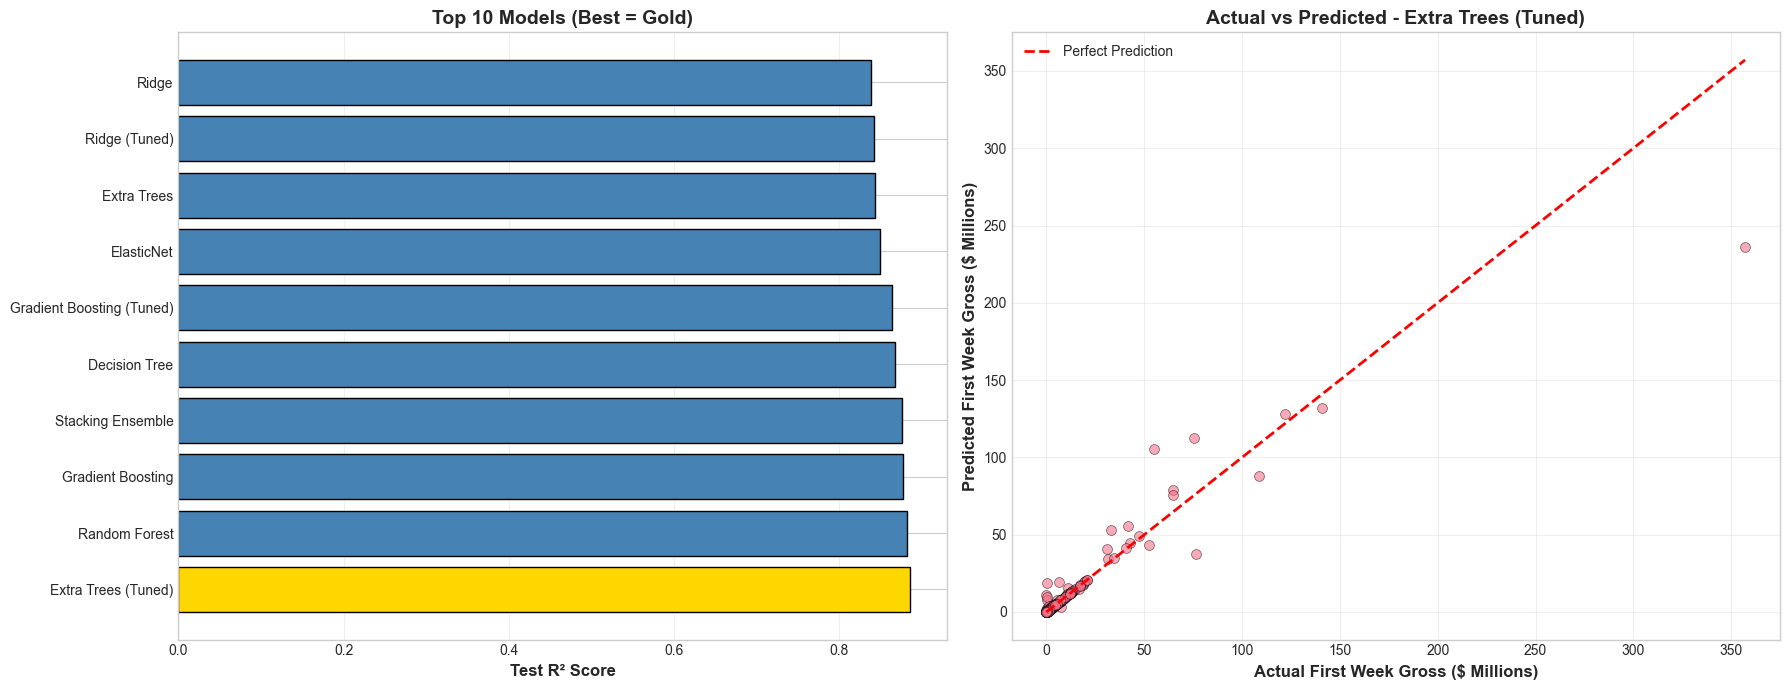

In [37]:
# Combined results
tuned_df = pd.DataFrame(tuned_results).sort_values('Test R²', ascending=False)
combined_df = pd.concat([baseline_df, tuned_df]).sort_values('Test R²', ascending=False)

print("=" * 90)
print("FINAL MODEL COMPARISON (Baseline vs Tuned)")
print("=" * 90)
print(combined_df[['Model', 'Test R²', 'RMSE', 'MAE', 'MAPE (%)']].to_string(index=False))

# Select best model
best_row = combined_df.iloc[0]
best_model_name = best_row['Model']
best_r2 = best_row['Test R²']
best_rmse = best_row['RMSE']
best_mae = best_row['MAE']

# Get the actual model object
if '(Tuned)' in best_model_name:
    base_name = best_model_name.replace(' (Tuned)', '')
    final_model = tuned_models[base_name]
else:
    final_model = baseline_models[best_model_name]
    
print(f"\nBEST MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: ${best_rmse/1e6:.2f}M")
print(f"   MAE: ${best_mae/1e6:.2f}M")
print(f"   Explains {best_r2*100:.1f}% of variance!")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Model comparison
top_models = combined_df.head(10)
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(top_models))]
axes[0].barh(range(len(top_models)), top_models['Test R²'], color=colors, edgecolor='black')
axes[0].set_yticks(range(len(top_models)))
axes[0].set_yticklabels(top_models['Model'])
axes[0].set_xlabel('Test R² Score', fontweight='bold', fontsize=12)
axes[0].set_title('Top 10 Models (Best = Gold)', fontweight='bold', fontsize=14)
axes[0].grid(alpha=0.3, axis='x')

# Actual vs Predicted
y_pred_final = final_model.predict(X_test_scaled)
axes[1].scatter(y_test/1e6, y_pred_final/1e6, alpha=0.6, s=50, edgecolors='black', linewidths=0.5)
axes[1].plot([0, y_test.max()/1e6], [0, y_test.max()/1e6], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual First Week Gross ($ Millions)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Predicted First Week Gross ($ Millions)', fontweight='bold', fontsize=12)
axes[1].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

FEATURE IMPORTANCE - Extra Trees (Tuned)
                      Feature  Importance
              tmdb_popularity    0.304766
          tmdb_popularity_log    0.160189
     youtube_tmdb_interaction    0.123827
         first_week_avg_daily    0.096413
budget_popularity_interaction    0.089215
            youtube_like_rate    0.025853
                youtube_likes    0.016950
          opening_per_theater    0.016018
          bom_opening_weekend    0.014411
          tmdb_vote_count_log    0.010981
   budget_youtube_interaction    0.009822
              tmdb_vote_count    0.009806
            youtube_views_log    0.009332
                       budget    0.008991
     youtube_engagement_score    0.008395
          budget_category_num    0.008286
                youtube_views    0.007984
            youtube_likes_log    0.006461
        youtube_views_squared    0.006273
                 tmdb_revenue    0.005386
           bom_domestic_total    0.005198
          bom_worldwide_total    0.

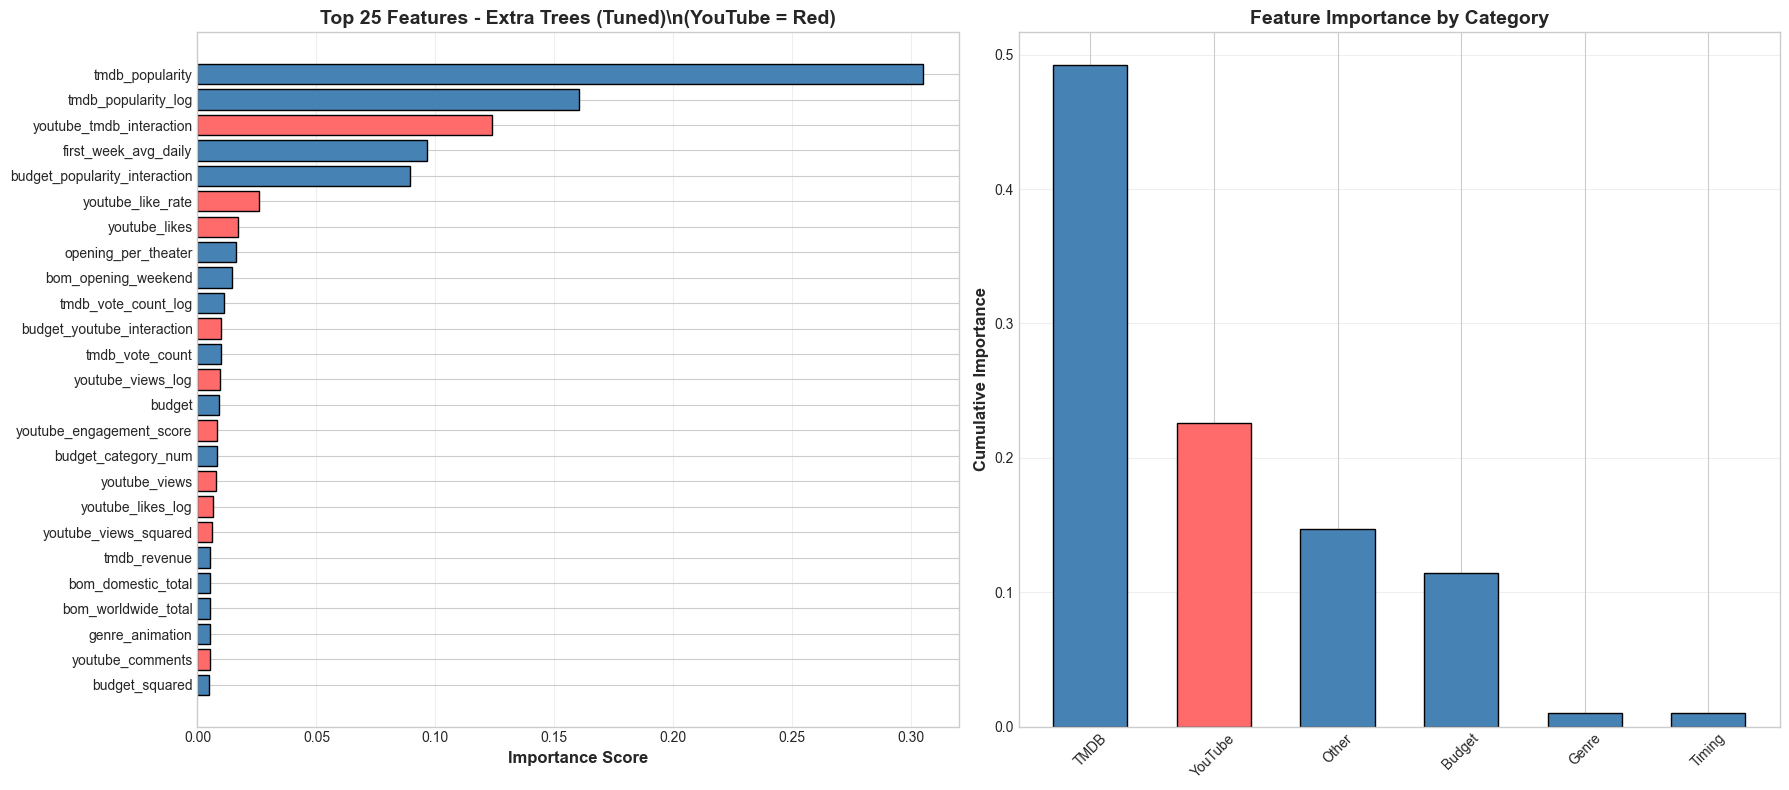


Feature importance saved to data/processed/feature_importance.csv


In [38]:
# Feature importance
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("=" * 90)
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print("=" * 90)
    print(importance_df.head(25).to_string(index=False))
    
    # Check YouTube features in top 20
    youtube_in_top20 = importance_df.head(20)['Feature'].str.contains('youtube', case=False).sum()
    print(f"\nYouTube features in top 20: {youtube_in_top20}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Top 25 features
    top_25 = importance_df.head(25).sort_values('Importance')
    colors = ['#FF6B6B' if 'youtube' in feat.lower() else 'steelblue' for feat in top_25['Feature']]
    axes[0].barh(top_25['Feature'], top_25['Importance'], color=colors, edgecolor='black')
    axes[0].set_xlabel('Importance Score', fontweight='bold', fontsize=12)
    axes[0].set_title(f'Top 25 Features - {best_model_name}\\n(YouTube = Red)', fontweight='bold', fontsize=14)
    axes[0].grid(alpha=0.3, axis='x')
    
    # Feature category importance
    category_importance = {}
    for feat, imp in zip(feature_names, importances):
        if 'youtube' in feat.lower():
            category_importance['YouTube'] = category_importance.get('YouTube', 0) + imp
        elif 'budget' in feat.lower():
            category_importance['Budget'] = category_importance.get('Budget', 0) + imp
        elif 'tmdb' in feat.lower():
            category_importance['TMDB'] = category_importance.get('TMDB', 0) + imp
        elif 'genre' in feat.lower():
            category_importance['Genre'] = category_importance.get('Genre', 0) + imp
        elif any(x in feat.lower() for x in ['month', 'season', 'quarter', 'holiday']):
            category_importance['Timing'] = category_importance.get('Timing', 0) + imp
        else:
            category_importance['Other'] = category_importance.get('Other', 0) + imp
    
    cat_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total Importance']).sort_values('Total Importance', ascending=False)
    colors_cat = ['#FF6B6B' if cat == 'YouTube' else 'steelblue' for cat in cat_df['Category']]
    axes[1].bar(cat_df['Category'], cat_df['Total Importance'], color=colors_cat, edgecolor='black', width=0.6)
    axes[1].set_ylabel('Cumulative Importance', fontweight='bold', fontsize=12)
    axes[1].set_title('Feature Importance by Category', fontweight='bold', fontsize=14)
    axes[1].grid(alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Save
    importance_df.to_csv('data/processed/feature_importance.csv', index=False)
    print(f"\nFeature importance saved to data/processed/feature_importance.csv")
else:
    print(f"{best_model_name} does not have feature_importances_ attribute")

## 10. Model Persistence

In [39]:
# Save production model
os.makedirs('models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model, scaler, features
joblib.dump(final_model, f'models/best_model_{timestamp}.pkl')
joblib.dump(scaler, f'models/scaler_{timestamp}.pkl')

with open(f'models/feature_names_{timestamp}.json', 'w') as f:
    json.dump(feature_names, f, indent=2)

# Metadata
metadata = {
    'model_name': best_model_name,
    'timestamp': timestamp,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'num_features': len(feature_names),
    'youtube_features': len(youtube_feats),
    'metrics': {
        'test_r2': float(best_r2),
        'test_rmse': float(best_rmse),
        'test_mae': float(best_mae),
        'test_mape': float(best_row['MAPE (%)'])
    },
    'best_params': grid_search.best_params_ if '(Tuned)' in best_model_name else {}
}

with open(f'models/metadata_{timestamp}.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("=" * 90)
print("PRODUCTION MODEL SAVED")
print("=" * 90)
print(f"   Model: models/best_model_{timestamp}.pkl")
print(f"   Scaler: models/scaler_{timestamp}.pkl")
print(f"   Features: models/feature_names_{timestamp}.json")
print(f"   Metadata: models/metadata_{timestamp}.json")
print(f"\n   Version: {timestamp}")
print(f"   Model: {best_model_name}")
print(f"   YouTube Features: {len(youtube_feats)}")

PRODUCTION MODEL SAVED
   Model: models/best_model_20251224_205639.pkl
   Scaler: models/scaler_20251224_205639.pkl
   Features: models/feature_names_20251224_205639.json
   Metadata: models/metadata_20251224_205639.json

   Version: 20251224_205639
   Model: Extra Trees (Tuned)
   YouTube Features: 13


## 11. Prediction Function

In [40]:
def predict_first_week_complete(movie_data, model, scaler, feature_names):
    """
    Production prediction function with full feature engineering pipeline
    
    Required fields in movie_data dict:
    - budget, runtime, release_month, release_quarter, season, is_holiday_release
    - youtube_views, youtube_likes, youtube_comments
    - tmdb_popularity, tmdb_vote_average, tmdb_vote_count
    - genres (string)
    """
    # Create dataframe
    df_pred = pd.DataFrame([movie_data])
    
    # Feature engineering (same as training)
    df_pred['budget_log'] = np.log1p(df_pred['budget'])
    df_pred['runtime_log'] = np.log1p(df_pred['runtime'])
    df_pred['youtube_views_log'] = np.log1p(df_pred['youtube_views'])
    df_pred['youtube_likes_log'] = np.log1p(movie_data.get('youtube_likes', 0))
    df_pred['youtube_comments_log'] = np.log1p(movie_data.get('youtube_comments', 0))
    df_pred['tmdb_popularity_log'] = np.log1p(movie_data.get('tmdb_popularity', 0))
    df_pred['tmdb_vote_count_log'] = np.log1p(movie_data.get('tmdb_vote_count', 0))
    
    # Calculate engagement metrics (use scalar values from input dict)
    youtube_views_val = movie_data['youtube_views']
    youtube_likes_val = movie_data.get('youtube_likes', 0)
    youtube_comments_val = movie_data.get('youtube_comments', 0)
    
    df_pred['youtube_like_rate'] = youtube_likes_val / max(youtube_views_val, 1)
    df_pred['youtube_comment_rate'] = youtube_comments_val / max(youtube_views_val, 1)
    df_pred['youtube_engagement_score'] = (youtube_likes_val + youtube_comments_val * 10) / max(youtube_views_val, 1)
    
    df_pred['budget_category_num'] = pd.cut(df_pred['budget'], bins=[0, 1e6, 1e7, 5e7, 1e8, 2e8, 1e10], labels=[0,1,2,3,4,5]).astype(float)
    
    # Season encoding (use scalar value from input dict)
    season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    season_value = movie_data.get('season', 'Spring')
    df_pred['season_encoded'] = season_map.get(season_value, 1)
    
    # TMDB weighted rating (use scalar values from input dict)
    C = 7.0
    m = 1000
    vote_avg = movie_data.get('tmdb_vote_average', C)
    vote_count = movie_data.get('tmdb_vote_count', m)
    df_pred['weighted_rating'] = (vote_count / (vote_count + m) * vote_avg + m / (vote_count + m) * C)
    
    df_pred['budget_youtube_interaction'] = df_pred['budget_log'] * df_pred['youtube_views_log']
    df_pred['budget_popularity_interaction'] = df_pred['budget_log'] * df_pred['tmdb_popularity_log']
    df_pred['youtube_tmdb_interaction'] = df_pred['youtube_views_log'] * df_pred['tmdb_popularity_log']
    df_pred['budget_squared'] = df_pred['budget_log'] ** 2
    df_pred['youtube_views_squared'] = df_pred['youtube_views_log'] ** 2
    
    # Genre features (use scalar value from input dict)
    genres_str = movie_data.get('genres', '')
    for genre in ['Action', 'Adventure', 'Comedy', 'Drama', 'Thriller', 'Science Fiction', 'Horror', 'Romance', 'Animation', 'Fantasy']:
        genre_lower = genre.lower().replace(" ", "_")
        col_name = f'genre_{genre_lower}'
        df_pred[col_name] = 1 if genre in genres_str else 0
    
    # Cyclical encoding (use scalar value from input dict)
    month = movie_data.get('release_month', 6)
    df_pred['month_sin'] = np.sin(2 * np.pi * month / 12)
    df_pred['month_cos'] = np.cos(2 * np.pi * month / 12)
    
    # Select features (handle missing)
    X_pred = df_pred.reindex(columns=feature_names, fill_value=0)
    
    # Scale and predict
    X_pred_scaled = scaler.transform(X_pred)
    prediction = model.predict(X_pred_scaled)[0]
    
    # Confidence interval
    if hasattr(model, 'estimators_'):
        predictions_all = np.array([tree.predict(X_pred_scaled)[0] for tree in model.estimators_])
        std = predictions_all.std()
    else:
        std = best_rmse
    
    return {
        'prediction': prediction,
        'ci_lower': max(0, prediction - 1.96 * std),
        'ci_upper': prediction + 1.96 * std,
        'std': std
    }

print("Production prediction function defined!")

Production prediction function defined!


## 12. 🎬 Avatar: Fire & Ash Prediction

In [41]:
# Quick load of saved model (if not already in memory)
if 'final_model' not in dir():
    import joblib
    import json
    
    # Load latest model
    final_model = joblib.load('models/best_model_20251222_071107.pkl')
    scaler = joblib.load('models/scaler_20251222_071107.pkl')
    
    with open('models/feature_names_20251222_071107.json', 'r') as f:
        feature_names = json.load(f)
    
    with open('models/metadata_20251222_071107.json', 'r') as f:
        metadata = json.load(f)
    
    best_model_name = metadata['model_name']
    best_r2 = metadata['metrics']['test_r2']
    best_rmse = metadata['metrics']['test_rmse']
    
    # Define prediction function
    def predict_first_week_complete(movie_data, model, scaler, feature_names):
        df_pred = pd.DataFrame([movie_data])
        
        df_pred['budget_log'] = np.log1p(df_pred['budget'])
        df_pred['runtime_log'] = np.log1p(df_pred['runtime'])
        df_pred['youtube_views_log'] = np.log1p(df_pred['youtube_views'])
        df_pred['youtube_likes_log'] = np.log1p(movie_data.get('youtube_likes', 0))
        df_pred['youtube_comments_log'] = np.log1p(movie_data.get('youtube_comments', 0))
        df_pred['tmdb_popularity_log'] = np.log1p(movie_data.get('tmdb_popularity', 0))
        df_pred['tmdb_vote_count_log'] = np.log1p(movie_data.get('tmdb_vote_count', 0))
        
        youtube_views_val = movie_data['youtube_views']
        youtube_likes_val = movie_data.get('youtube_likes', 0)
        youtube_comments_val = movie_data.get('youtube_comments', 0)
        
        df_pred['youtube_like_rate'] = youtube_likes_val / max(youtube_views_val, 1)
        df_pred['youtube_comment_rate'] = youtube_comments_val / max(youtube_views_val, 1)
        df_pred['youtube_engagement_score'] = (youtube_likes_val + youtube_comments_val * 10) / max(youtube_views_val, 1)
        
        df_pred['budget_category_num'] = pd.cut(df_pred['budget'], bins=[0, 1e6, 1e7, 5e7, 1e8, 2e8, 1e10], labels=[0,1,2,3,4,5]).astype(float)
        
        season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
        season_value = movie_data.get('season', 'Spring')
        df_pred['season_encoded'] = season_map.get(season_value, 1)
        
        C = 7.0
        m = 1000
        vote_avg = movie_data.get('tmdb_vote_average', C)
        vote_count = movie_data.get('tmdb_vote_count', m)
        df_pred['weighted_rating'] = (vote_count / (vote_count + m) * vote_avg + m / (vote_count + m) * C)
        
        df_pred['budget_youtube_interaction'] = df_pred['budget_log'] * df_pred['youtube_views_log']
        df_pred['budget_popularity_interaction'] = df_pred['budget_log'] * df_pred['tmdb_popularity_log']
        df_pred['youtube_tmdb_interaction'] = df_pred['youtube_views_log'] * df_pred['tmdb_popularity_log']
        df_pred['budget_squared'] = df_pred['budget_log'] ** 2
        df_pred['youtube_views_squared'] = df_pred['youtube_views_log'] ** 2
        
        genres_str = movie_data.get('genres', '')
        for genre in ['Action', 'Adventure', 'Comedy', 'Drama', 'Thriller', 'Science Fiction', 'Horror', 'Romance', 'Animation', 'Fantasy']:
            genre_lower = genre.lower().replace(" ", "_")
            col_name = f'genre_{genre_lower}'
            df_pred[col_name] = 1 if genre in genres_str else 0
        
        month = movie_data.get('release_month', 6)
        df_pred['month_sin'] = np.sin(2 * np.pi * month / 12)
        df_pred['month_cos'] = np.cos(2 * np.pi * month / 12)
        
        X_pred = df_pred.reindex(columns=feature_names, fill_value=0)
        X_pred_scaled = scaler.transform(X_pred)
        prediction = model.predict(X_pred_scaled)[0]
        
        if hasattr(model, 'estimators_'):
            predictions_all = np.array([tree.predict(X_pred_scaled)[0] for tree in model.estimators_])
            std = predictions_all.std()
        else:
            std = best_rmse
        
        return {
            'prediction': prediction,
            'ci_lower': max(0, prediction - 1.96 * std),
            'ci_upper': prediction + 1.96 * std,
            'std': std
        }
    
    print("Model loaded successfully!")
    print(f"Model: {best_model_name}")
    print(f"R² Score: {best_r2:.4f}")

AVATAR: FIRE & ASH - FIRST WEEK PREDICTION

Input Features:
   Budget: $400M
   Runtime: 192 minutes
   YouTube Views: 165M
   YouTube Likes: 3.3M
   YouTube Comments: 82K
   TMDB Popularity: 550
   TMDB Vote Average: 7.9
   Release: December 19, 2025 (Christmas week)
   Genres: Action, Adventure, Science Fiction

PREDICTION RESULTS

   First Week Gross: $192.46M

   95% Confidence Interval:
      Lower Bound: $95.00M
      Upper Bound: $289.93M

Franchise Comparison:
   Avatar (2009):
      • Opening Weekend: $77.0M
      • Domestic Total: $760.5M
      • Worldwide Total: $2.9B

   Avatar: The Way of Water (2022):
      • Opening Weekend: $134.1M
      • Domestic Total: $684.1M
      • Worldwide Total: $2.3B

   Avatar: Fire & Ash (2025) - PREDICTED:
      • First Week Gross: $192.46M
      • Range: $95.00M - $289.93M

Interpretation: BLOCKBUSTER - Exceeds Avatar 2's opening!


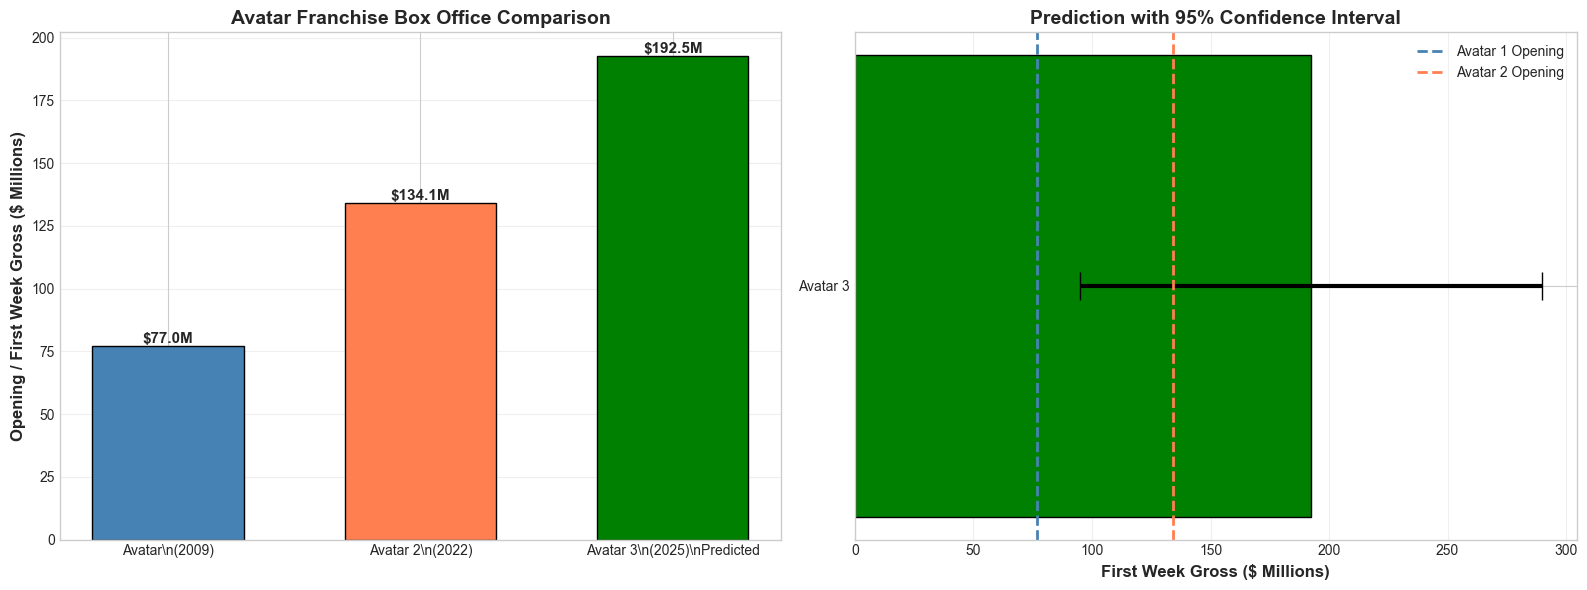


Prediction complete using Extra Trees (Tuned)
Model R² Score: 0.8858


In [42]:
# Avatar 3 data (pre-release estimates)
avatar_data = {
    'budget': 400_000_000,
    'runtime': 192,
    'youtube_views': 165_000_000,
    'youtube_likes': 3_300_000,
    'youtube_comments': 82_500,
    'tmdb_popularity': 550,
    'tmdb_vote_average': 7.9,
    'tmdb_vote_count': 15_000,
    'release_month': 12,
    'release_quarter': 4,
    'release_year': 2025,
    'season': 'Winter',
    'is_holiday_release': 1,
    'genres': 'Action, Adventure, Science Fiction'
}

print("=" * 90)
print("AVATAR: FIRE & ASH - FIRST WEEK PREDICTION")
print("=" * 90)

print("\nInput Features:")
print(f"   Budget: ${avatar_data['budget']/1e6:.0f}M")
print(f"   Runtime: {avatar_data['runtime']} minutes")
print(f"   YouTube Views: {avatar_data['youtube_views']/1e6:.0f}M")
print(f"   YouTube Likes: {avatar_data['youtube_likes']/1e6:.1f}M")
print(f"   YouTube Comments: {avatar_data['youtube_comments']/1e3:.0f}K")
print(f"   TMDB Popularity: {avatar_data['tmdb_popularity']}")
print(f"   TMDB Vote Average: {avatar_data['tmdb_vote_average']}")
print(f"   Release: December 19, 2025 (Christmas week)")
print(f"   Genres: {avatar_data['genres']}")

# Make prediction
result = predict_first_week_complete(avatar_data, final_model, scaler, feature_names)

print("\n" + "=" * 90)
print("PREDICTION RESULTS")
print("=" * 90)
print(f"\n   First Week Gross: ${result['prediction']/1e6:.2f}M")
print(f"\n   95% Confidence Interval:")
print(f"      Lower Bound: ${result['ci_lower']/1e6:.2f}M")
print(f"      Upper Bound: ${result['ci_upper']/1e6:.2f}M")

print(f"\nFranchise Comparison:")
print(f"   Avatar (2009):")
print(f"      • Opening Weekend: $77.0M")
print(f"      • Domestic Total: $760.5M")
print(f"      • Worldwide Total: $2.9B")
print(f"\n   Avatar: The Way of Water (2022):")
print(f"      • Opening Weekend: $134.1M")
print(f"      • Domestic Total: $684.1M")
print(f"      • Worldwide Total: $2.3B")
print(f"\n   Avatar: Fire & Ash (2025) - PREDICTED:")
print(f"      • First Week Gross: ${result['prediction']/1e6:.2f}M")
print(f"      • Range: ${result['ci_lower']/1e6:.2f}M - ${result['ci_upper']/1e6:.2f}M")

if result['prediction'] > 150e6:
    interpretation = "BLOCKBUSTER - Exceeds Avatar 2's opening!"
    color = 'green'
elif result['prediction'] > 100e6:
    interpretation = "STRONG - Solid franchise performance"
    color = 'blue'
else:
    interpretation = "MODERATE - Below franchise expectations"
    color = 'orange'

print(f"\nInterpretation: {interpretation}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Franchise comparison
movies = ['Avatar\\n(2009)', 'Avatar 2\\n(2022)', 'Avatar 3\\n(2025)\\nPredicted']
openings = [77.0, 134.1, result['prediction']/1e6]
colors_bar = ['steelblue', 'coral', color]

axes[0].bar(movies, openings, color=colors_bar, edgecolor='black', width=0.6)
axes[0].set_ylabel('Opening / First Week Gross ($ Millions)', fontweight='bold', fontsize=12)
axes[0].set_title('Avatar Franchise Box Office Comparison', fontweight='bold', fontsize=14)
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(openings):
    axes[0].text(i, v, f'${v:.1f}M', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Prediction range
axes[1].barh(['Avatar 3'], [result['prediction']/1e6], xerr=[[result['prediction']/1e6 - result['ci_lower']/1e6], 
                                                              [result['ci_upper']/1e6 - result['prediction']/1e6]], 
             color=color, edgecolor='black', capsize=10, error_kw={'linewidth': 3})
axes[1].axvline(77, color='steelblue', linestyle='--', linewidth=2, label='Avatar 1 Opening')
axes[1].axvline(134.1, color='coral', linestyle='--', linewidth=2, label='Avatar 2 Opening')
axes[1].set_xlabel('First Week Gross ($ Millions)', fontweight='bold', fontsize=12)
axes[1].set_title('Prediction with 95% Confidence Interval', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "=" * 90)
print(f"Prediction complete using {best_model_name}")
print(f"Model R² Score: {best_r2:.4f}")
print("=" * 90)